In [1]:
import pandas as pd

                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.005938
13683                          Eng

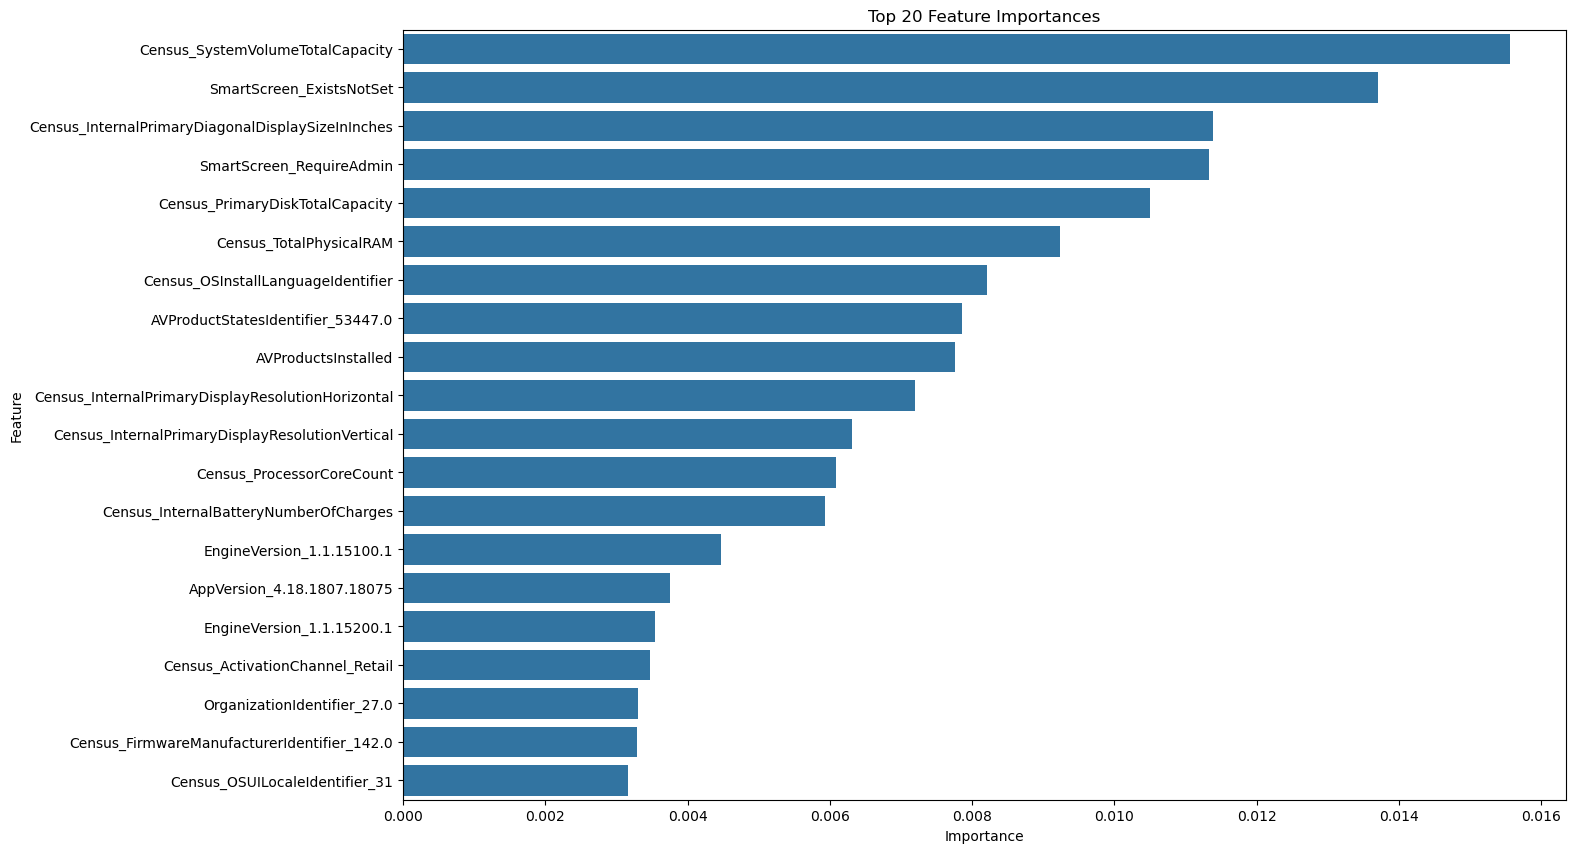


--- Guidance for Top 20 Feature Importances ---
This bar plot displays the top 20 features based on their importance in the Random Forest model.
Features with higher importance values contribute more significantly to the model's predictions.
Consider focusing on these features for feature engineering and understanding their role in the model.
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScr

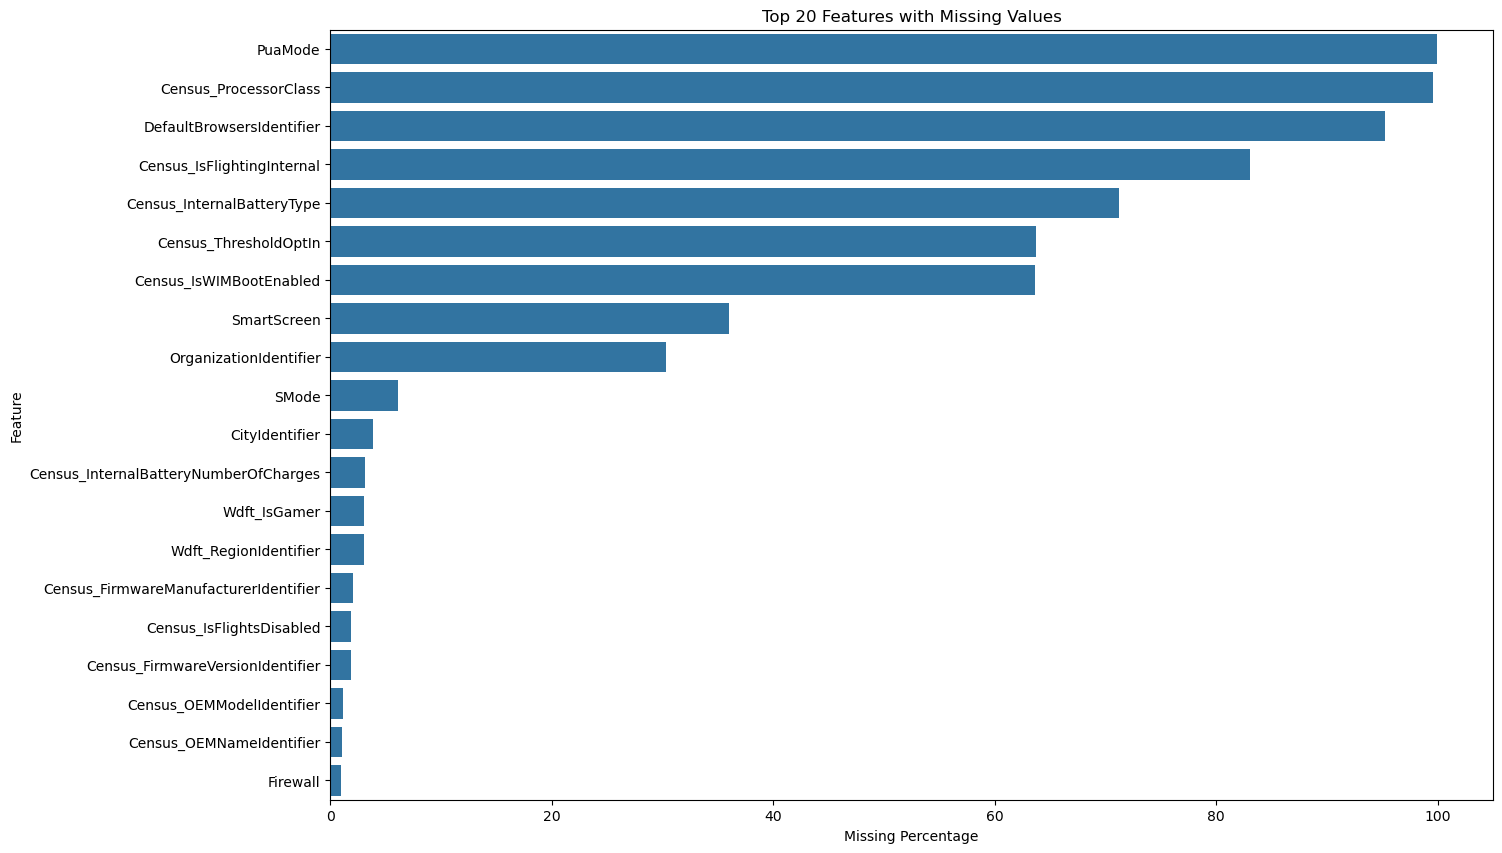


--- Guidance for Top 20 Features with Missing Values ---
This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.
Consider the following actions:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.
- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.


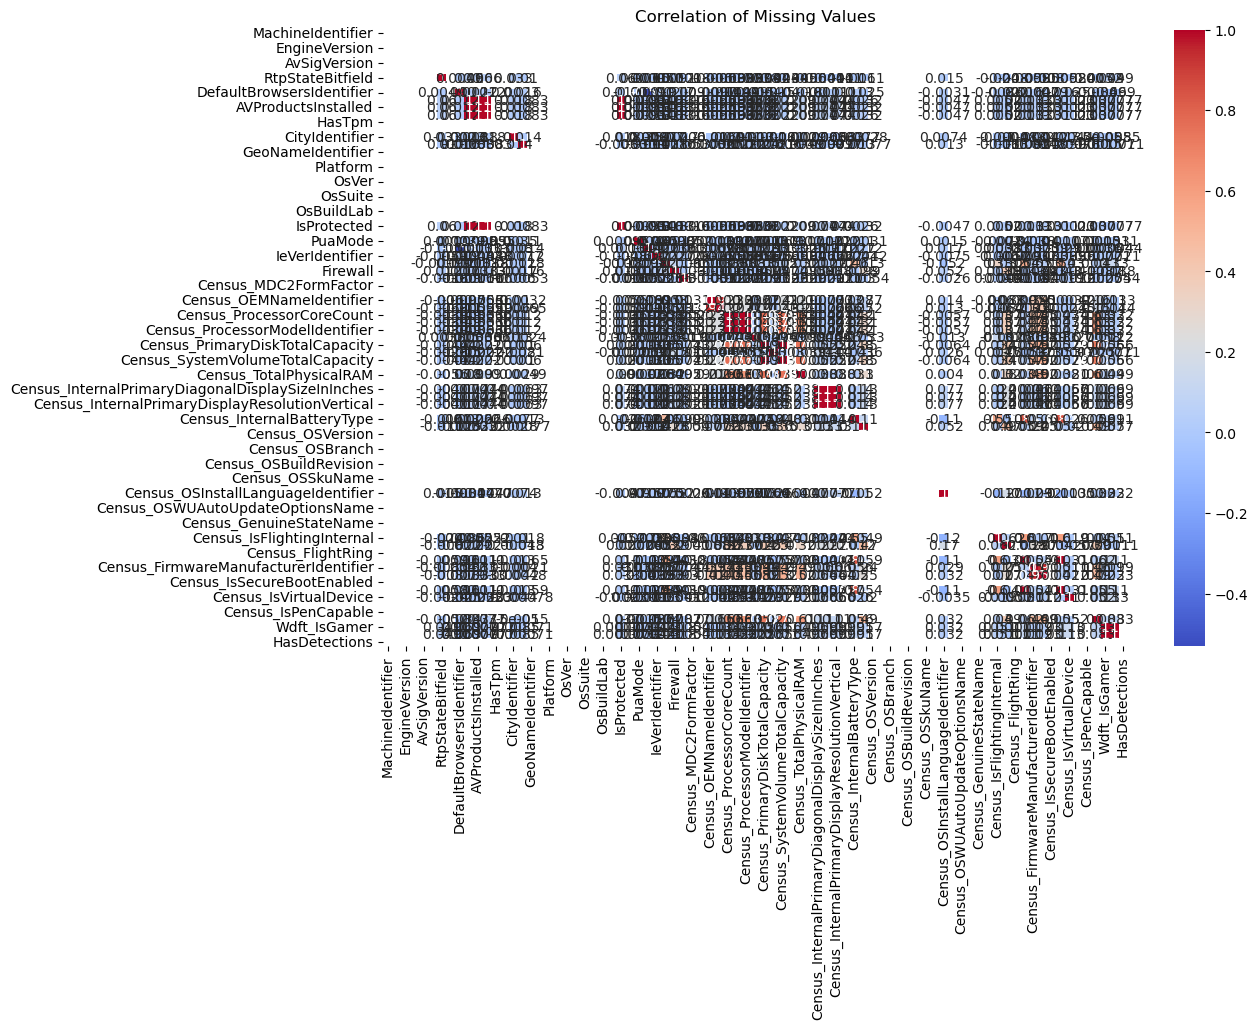


--- Guidance for Correlation of Missing Values ---
This heatmap shows the correlation between missing values of different features.
High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.
Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.


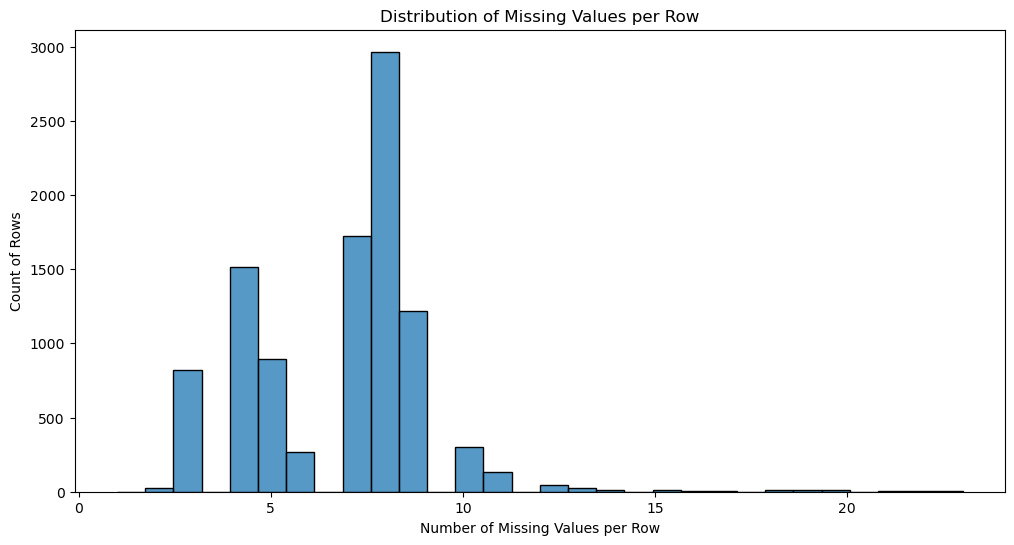


--- Guidance for Distribution of Missing Values per Row ---
This histogram shows the distribution of the number of missing values per row in the dataset.
Identify rows with a high number of missing values for potential removal or advanced imputation.
Rows with >50% missing values might be considered for removal.
                                                   CorrelationWithTarget
AVProductStatesIdentifier                                       0.111348
IsProtected                                                     0.065207
Census_TotalPhysicalRAM                                         0.059147
Census_PrimaryDiskTotalCapacity                                 0.054558
Census_ProcessorCoreCount                                       0.050934
Wdft_IsGamer                                                    0.047980
RtpStateBitfield                                                0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches               0.029988
LocaleEnglishNameIdentifier 

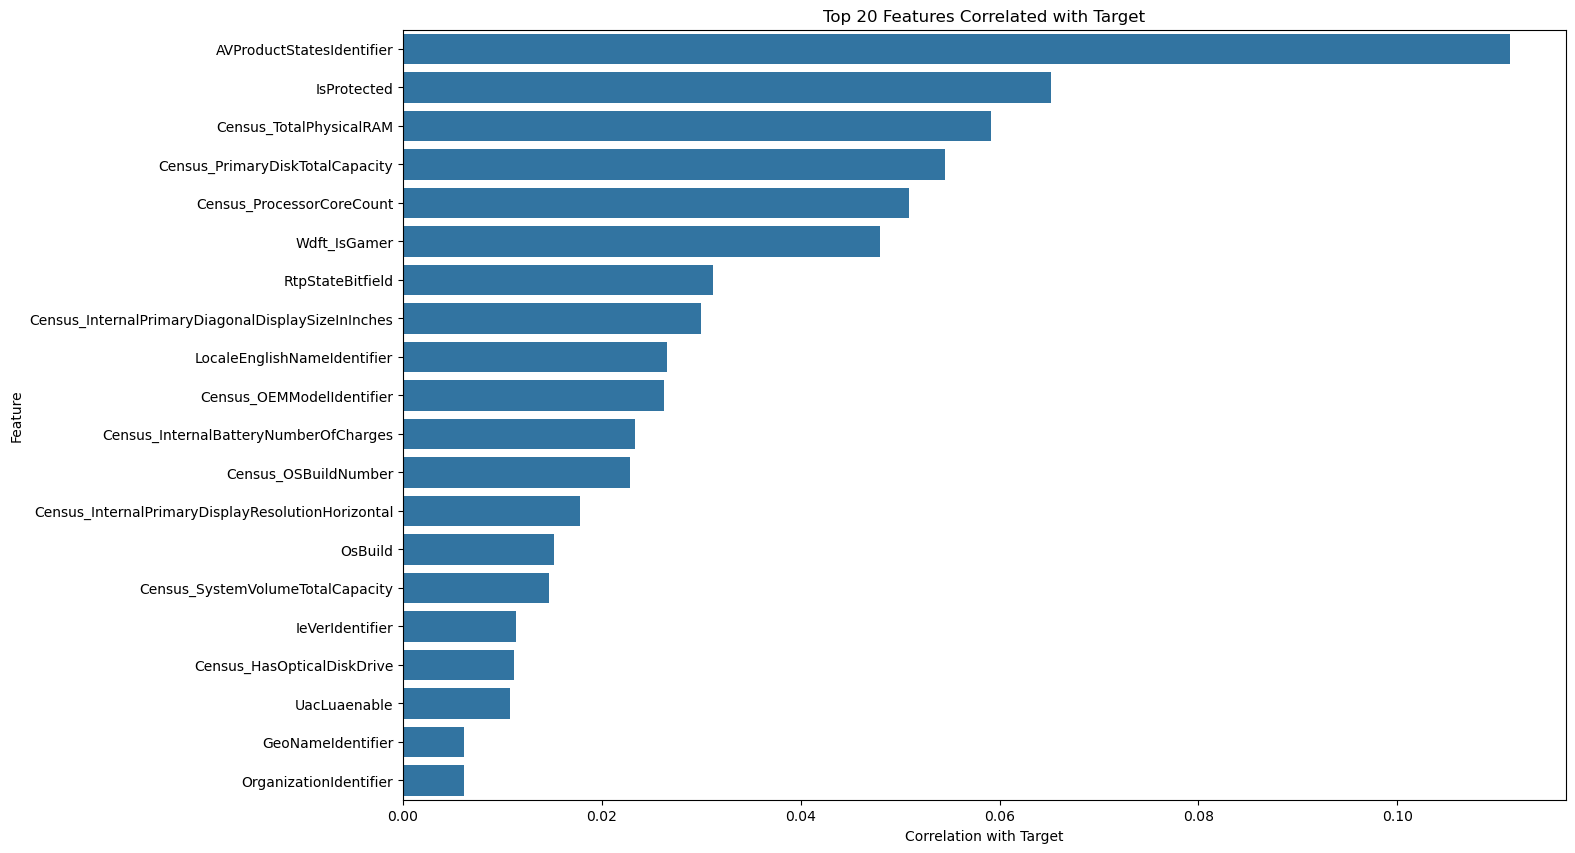


--- Guidance for Feature Correlation with Target ---
This bar plot shows the top 20 features with the highest correlation with the target variable.
High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.
Focus on these features for feature engineering and model building.

--- Contextual Insights and Recommendations ---
High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.
Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.
Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regres

In [2]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, save_yaml, save_json_file, clean_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Load feature metadata and manual updates
feature_metadata_path = paths['config']['feature_metadata']
manual_update_path = paths['config']['manual_feature_classification_update']
feature_metadata = load_yaml(feature_metadata_path)
manual_updates = load_yaml(manual_update_path)['manual_feature_classification_updates']

# Update the classified_data_type attribute in feature_metadata.yaml
for update in manual_updates:
    feature = update['Feature']
    new_classification = update['Manual Review and Update']
    if feature in feature_metadata['features']:
        feature_metadata['features'][feature]['classified_data_type'] = new_classification
    else:
        print(f"Feature {feature} not found in the existing metadata.")
save_yaml(feature_metadata, feature_metadata_path)

# Separate features into numeric and categorical based on classified_data_type
numeric_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'numerical']
categorical_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'categorical']

# Imputation strategies
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.named_steps['classifier'].feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df.head(20))  # Display the top 20 features

# Save the feature importance to a file
analysis_results_dir = paths['reports']['univariate_analysis']
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df.head(20))

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Calculate the correlation of missing values with each other
missing_corr = train_sample.isnull().corr()

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Feature Importances ---")
print("This bar plot displays the top 20 features based on their importance in the Random Forest model.")
print("Features with higher importance values contribute more significantly to the model's predictions.")
print("Consider focusing on these features for feature engineering and understanding their role in the model.")

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
missing_values = missing_values.sort_values(by='missing_percentage', ascending=False)

# Display the missing values table
print(missing_values.head(20))

# Save the missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plot missing values table
plt.figure(figsize=(15, 10))
sns.barplot(x='missing_percentage', y='column_name', data=missing_values.head(20))
plt.title('Top 20 Features with Missing Values')
plt.xlabel('Missing Percentage')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Features with Missing Values ---")
print("This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.")
print("Consider the following actions:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Guidance
print("\n--- Guidance for Correlation of Missing Values ---")
print("This heatmap shows the correlation between missing values of different features.")
print("High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.")
print("Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.")

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Guidance
print("\n--- Guidance for Distribution of Missing Values per Row ---")
print("This histogram shows the distribution of the number of missing values per row in the dataset.")
print("Identify rows with a high number of missing values for potential removal or advanced imputation.")
print("Rows with >50% missing values might be considered for removal.")

# Feature Correlation with Target
feature_corr_with_target = {f: float(meta['correlation_with_target']) for f, meta in feature_metadata['features'].items() if isinstance(meta['correlation_with_target'], (int, float)) and meta['correlation_with_target'] != ''}

feature_corr_with_target_df = pd.DataFrame.from_dict(feature_corr_with_target, orient='index', columns=['CorrelationWithTarget'])
feature_corr_with_target_df = feature_corr_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Display feature correlation with target table
print(feature_corr_with_target_df.head(20))

# Save feature correlation with target to a file
feature_corr_with_target_df.to_csv(os.path.join(analysis_results_dir, 'feature_corr_with_target.csv'))

# Plot feature correlation with target
plt.figure(figsize=(15, 10))
sns.barplot(x='CorrelationWithTarget', y=feature_corr_with_target_df.index[:20], data=feature_corr_with_target_df.head(20).reset_index())
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Feature Correlation with Target ---")
print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
print("Focus on these features for feature engineering and model building.")

print("\n--- Contextual Insights and Recommendations ---")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")
print("- Rows with >50% missing values: Consider dropping these rows or using advanced imputation techniques.")
print("- Features with high correlation to target: Pay special attention to these features as their missingness might contain predictive information.")


                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.005938
13683                          Eng

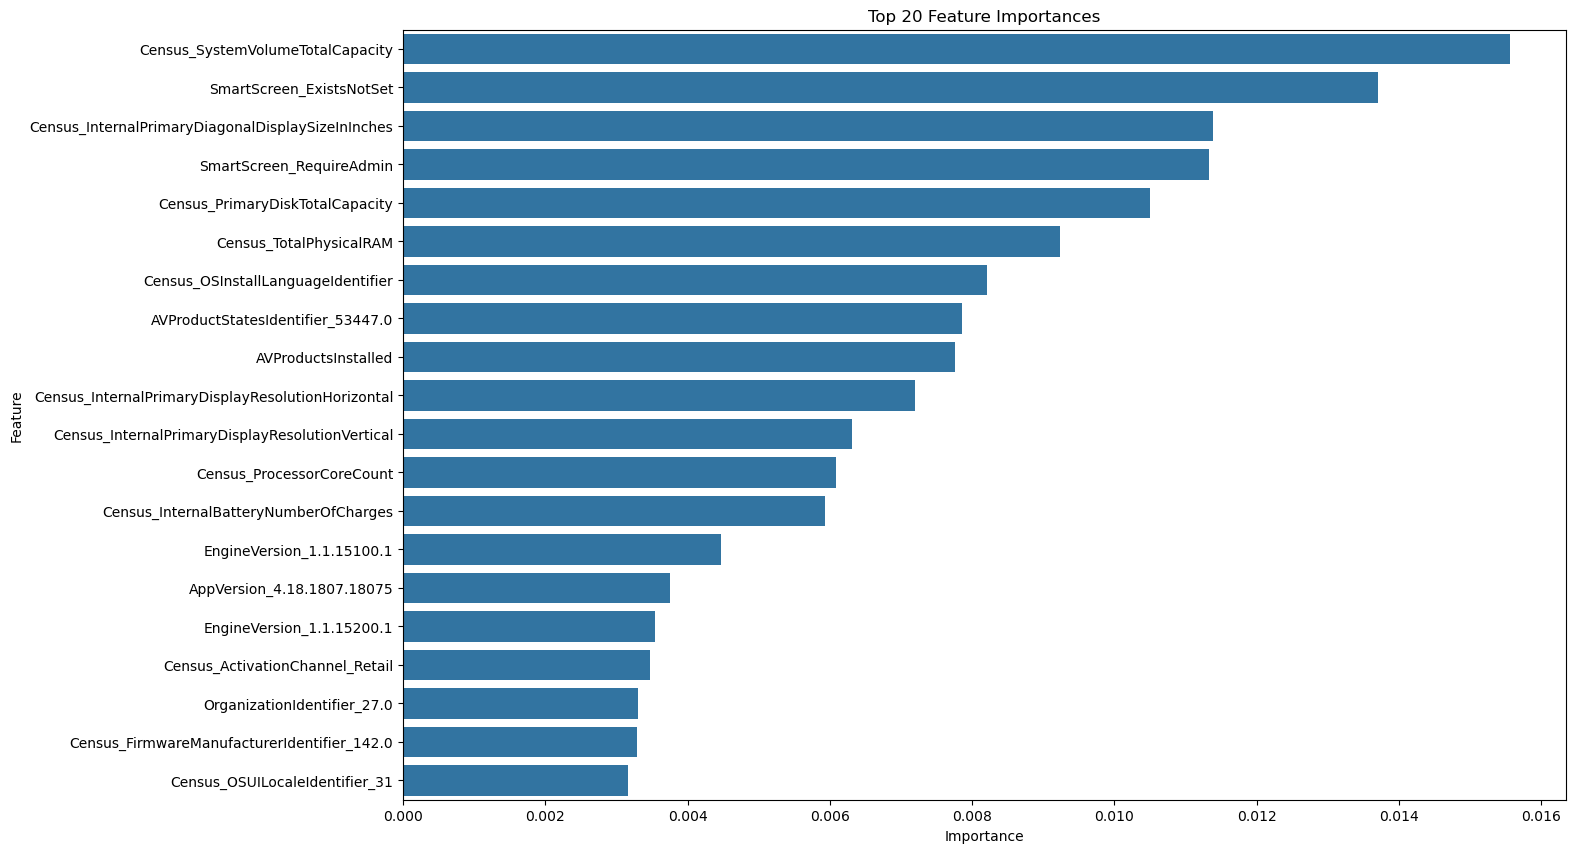


--- Guidance for Top 20 Feature Importances ---
This bar plot displays the top 20 features based on their importance in the Random Forest model.
Features with higher importance values contribute more significantly to the model's predictions.
Consider focusing on these features for feature engineering and understanding their role in the model.
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScr

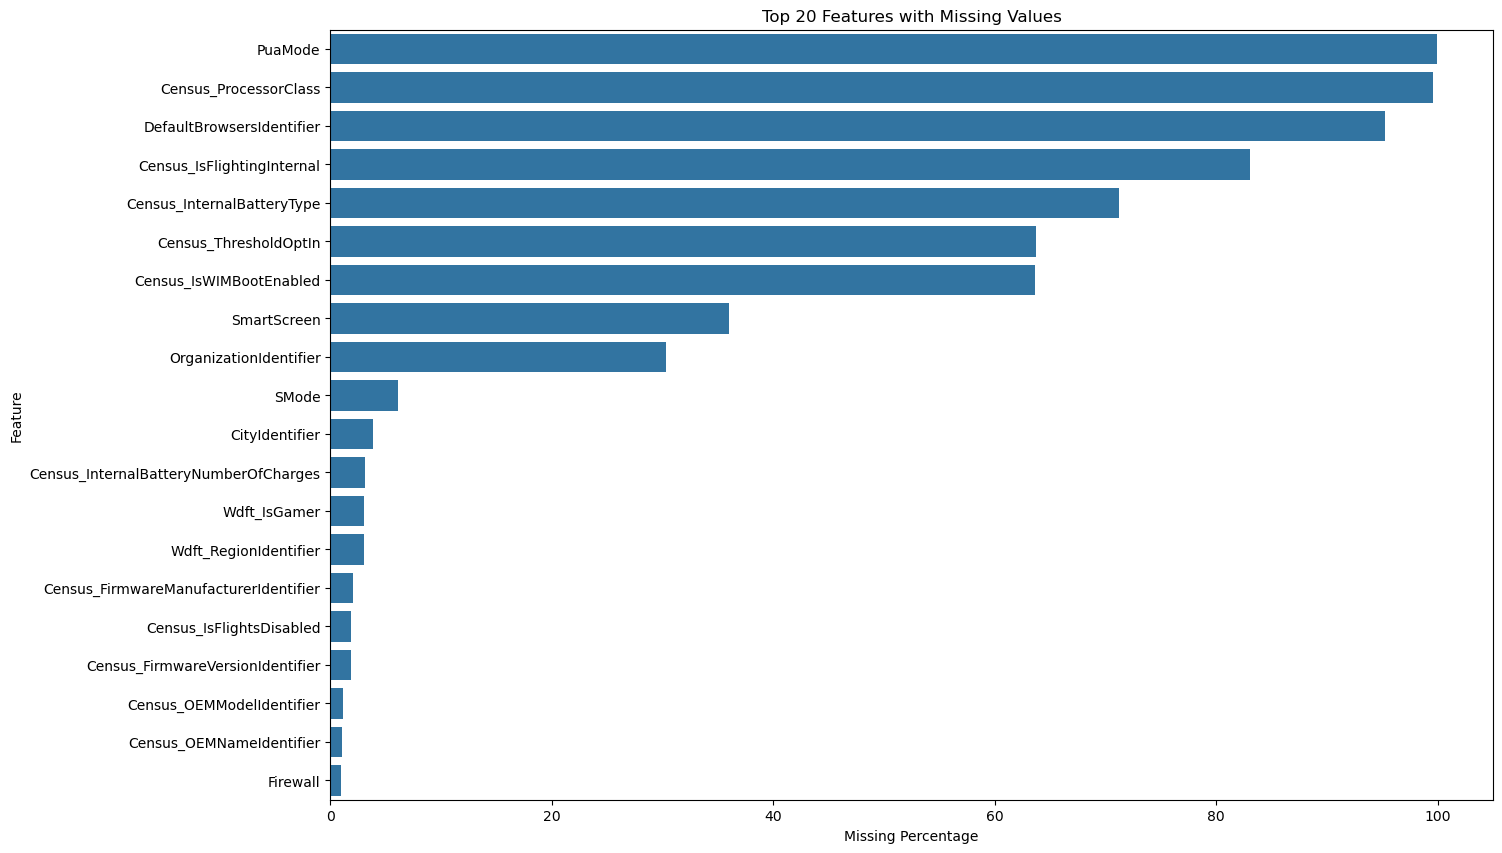


--- Guidance for Top 20 Features with Missing Values ---
This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.
Consider the following actions:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.
- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.


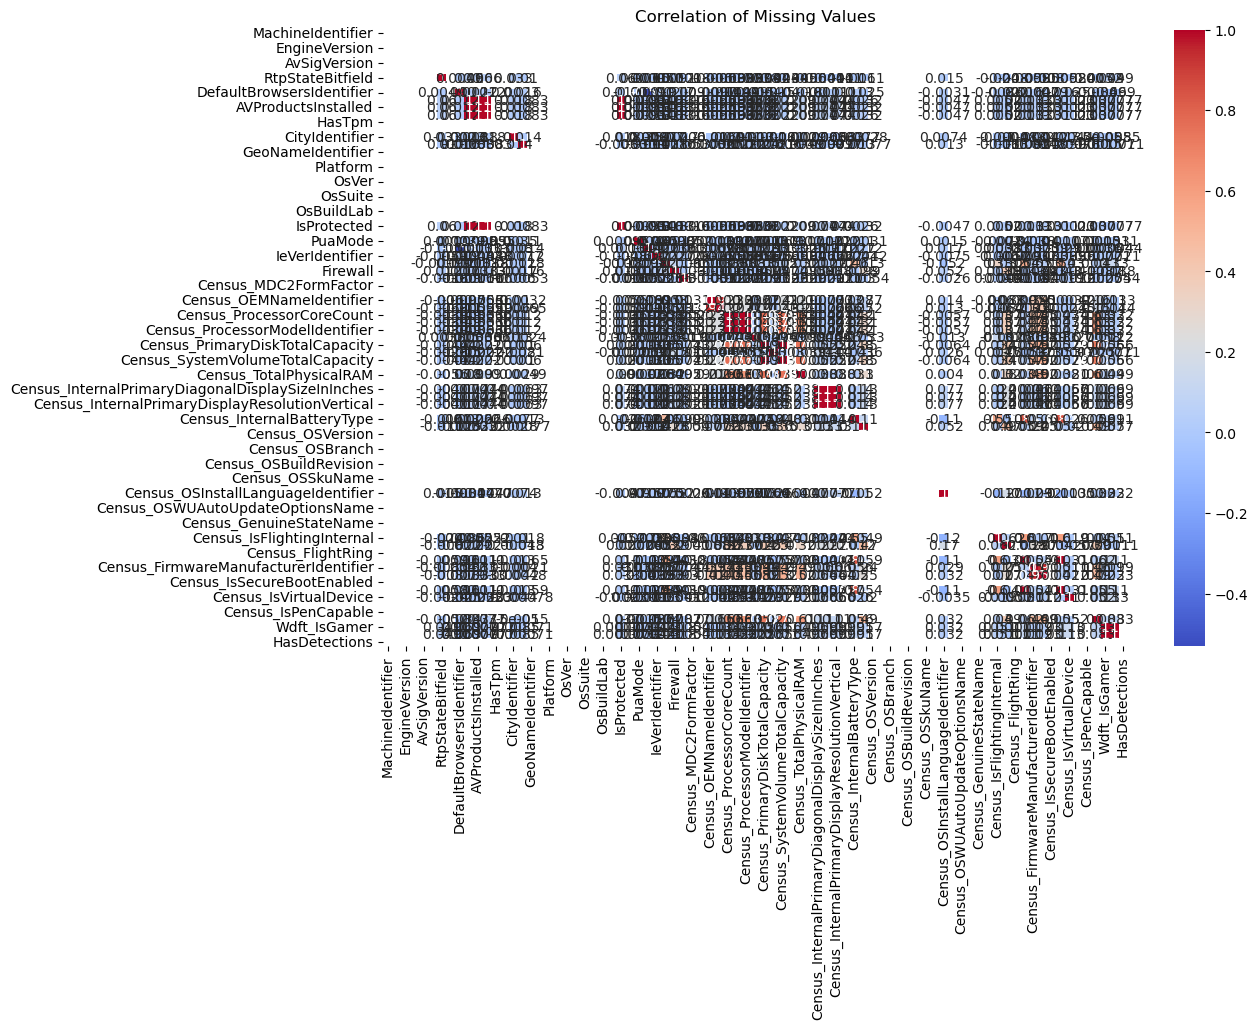


--- Guidance for Correlation of Missing Values ---
This heatmap shows the correlation between missing values of different features.
High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.
Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.


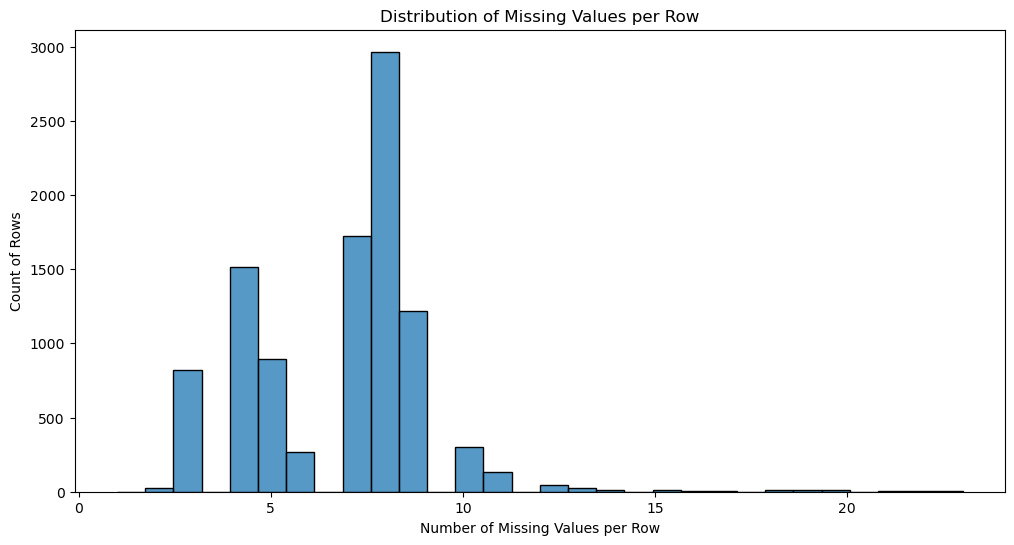


--- Guidance for Distribution of Missing Values per Row ---
This histogram shows the distribution of the number of missing values per row in the dataset.
Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.
                                                   CorrelationWithTarget
AVProductStatesIdentifier                                       0.111348
IsProtected                                                     0.065207
Census_TotalPhysicalRAM                                         0.059147
Census_PrimaryDiskTotalCapacity                                 0.054558
Census_ProcessorCoreCount                                       0.050934
Wdft_IsGamer                                                    0.047980
RtpStateBitfield                                                0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches               0.029988
LocaleEnglishNameIdentifier 

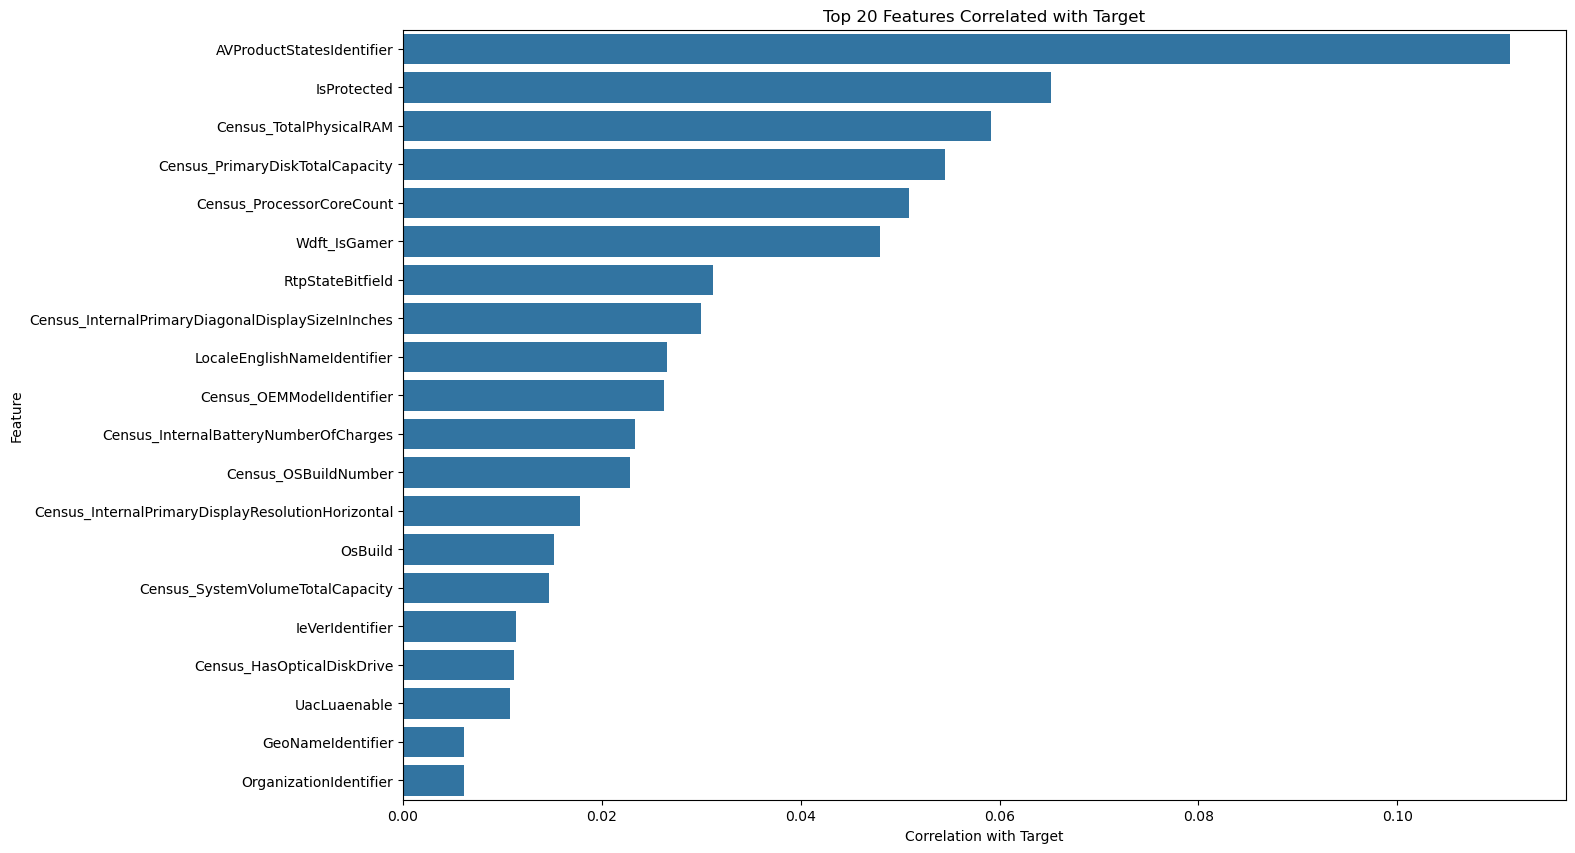


--- Guidance for Feature Correlation with Target ---
This bar plot shows the top 20 features with the highest correlation with the target variable.
High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.
Focus on these features for feature engineering and model building.

--- Contextual Insights and Recommendations ---
High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.
Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.
Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regres

In [2]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, save_yaml, save_json_file, clean_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Load feature metadata and manual updates
feature_metadata_path = paths['config']['feature_metadata']
manual_update_path = paths['config']['manual_feature_classification_update']
feature_metadata = load_yaml(feature_metadata_path)
manual_updates = load_yaml(manual_update_path)['manual_feature_classification_updates']

# Update the classified_data_type attribute in feature_metadata.yaml
for update in manual_updates:
    feature = update['Feature']
    new_classification = update['Manual Review and Update']
    if feature in feature_metadata['features']:
        feature_metadata['features'][feature]['classified_data_type'] = new_classification
    else:
        print(f"Feature {feature} not found in the existing metadata.")
save_yaml(feature_metadata, feature_metadata_path)

# Separate features into numeric and categorical based on classified_data_type
numeric_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'numerical']
categorical_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'categorical']

# Imputation strategies
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.named_steps['classifier'].feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df.head(20))  # Display the top 20 features

# Save the feature importance to a file
analysis_results_dir = paths['reports']['univariate_analysis']
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df.head(20))

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Calculate the correlation of missing values with each other
missing_corr = train_sample.isnull().corr()

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Feature Importances ---")
print("This bar plot displays the top 20 features based on their importance in the Random Forest model.")
print("Features with higher importance values contribute more significantly to the model's predictions.")
print("Consider focusing on these features for feature engineering and understanding their role in the model.")

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
missing_values = missing_values.sort_values(by='missing_percentage', ascending=False)

# Display the missing values table
print(missing_values.head(20))

# Save the missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plot missing values table
plt.figure(figsize=(15, 10))
sns.barplot(x='missing_percentage', y='column_name', data=missing_values.head(20))
plt.title('Top 20 Features with Missing Values')
plt.xlabel('Missing Percentage')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Features with Missing Values ---")
print("This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.")
print("Consider the following actions:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Guidance
print("\n--- Guidance for Correlation of Missing Values ---")
print("This heatmap shows the correlation between missing values of different features.")
print("High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.")
print("Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.")

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Guidance
print("\n--- Guidance for Distribution of Missing Values per Row ---")
print("This histogram shows the distribution of the number of missing values per row in the dataset.")
print("Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.")

# Clean up the temporary column
train_sample.drop(columns=['missing_count_per_row'], inplace=True)

# Load feature correlation with target from metadata
feature_corr_with_target = {f: meta['correlation_with_target'] for f, meta in feature_metadata['features'].items() if 'correlation_with_target' in meta}

# Filter out non-numeric correlation values
feature_corr_with_target = {k: v for k, v in feature_corr_with_target.items() if isinstance(v, (int, float))}

# Create DataFrame for feature correlation with target
feature_corr_with_target_df = pd.DataFrame.from_dict(feature_corr_with_target, orient='index', columns=['CorrelationWithTarget'])
feature_corr_with_target_df = feature_corr_with_target_df.astype(float).sort_values(by='CorrelationWithTarget', ascending=False)

# Display feature correlation with target table
print(feature_corr_with_target_df.head(20))

# Plot feature correlation with target
plt.figure(figsize=(15, 10))
sns.barplot(x='CorrelationWithTarget', y=feature_corr_with_target_df.index[:20], data=feature_corr_with_target_df.head(20).reset_index())
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Feature Correlation with Target ---")
print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
print("Focus on these features for feature engineering and model building.")

print("\n--- Contextual Insights and Recommendations ---")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")
print("- Rows with >50% missing values: Consider dropping these rows or using advanced imputation techniques.")
print("- Features with high correlation to target: Pay special attention to these features as their missingness might contain predictive information.")


                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.005938
13683                          Eng

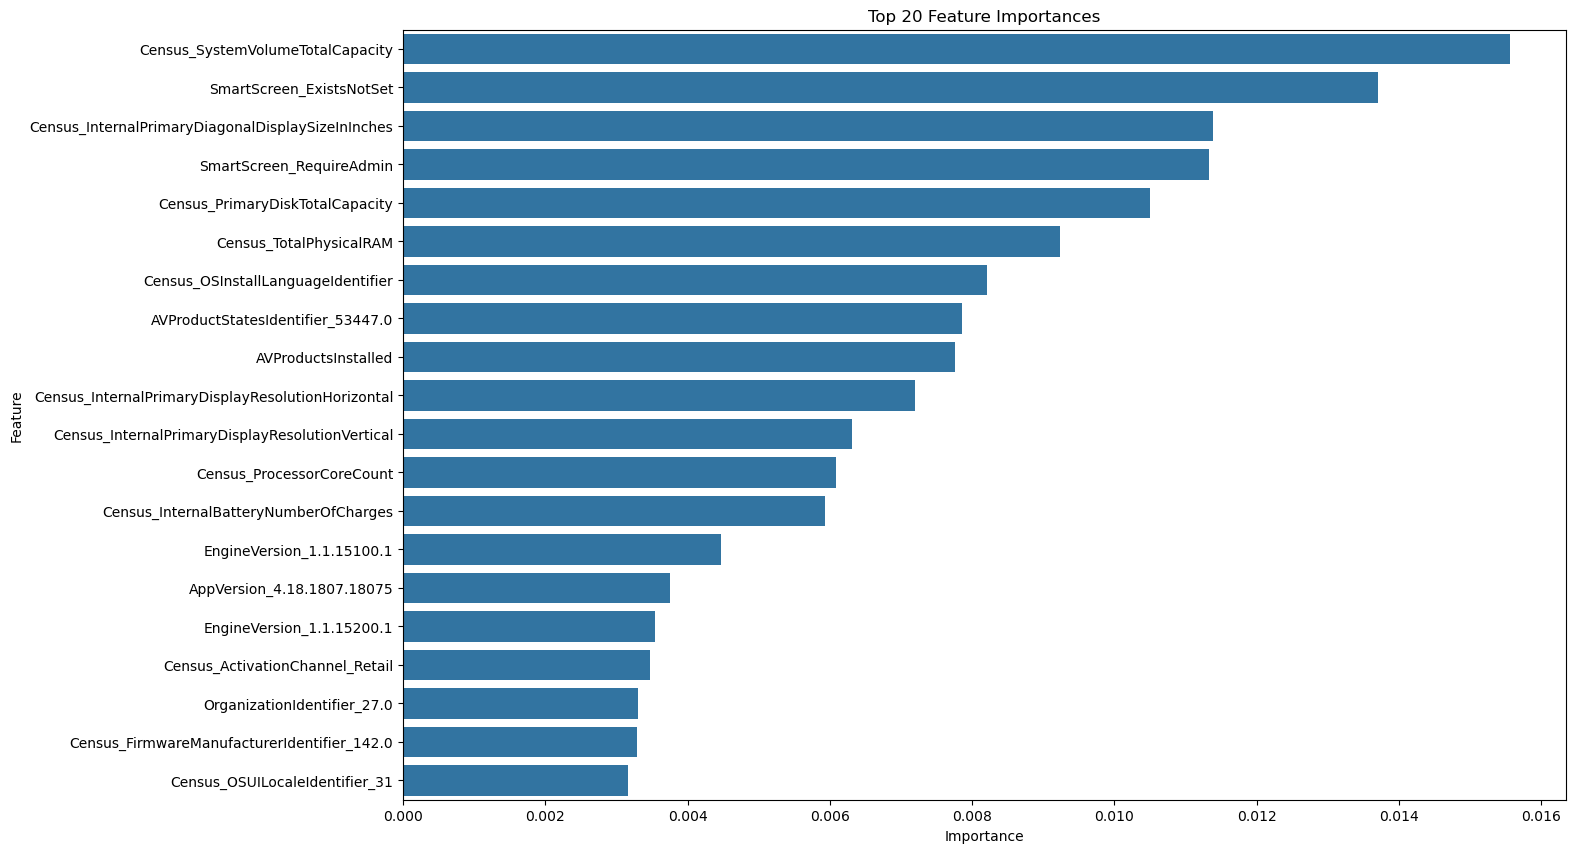


--- Guidance for Top 20 Feature Importances ---
This bar plot displays the top 20 features based on their importance in the Random Forest model.
Features with higher importance values contribute more significantly to the model's predictions.
Consider focusing on these features for feature engineering and understanding their role in the model.
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScr

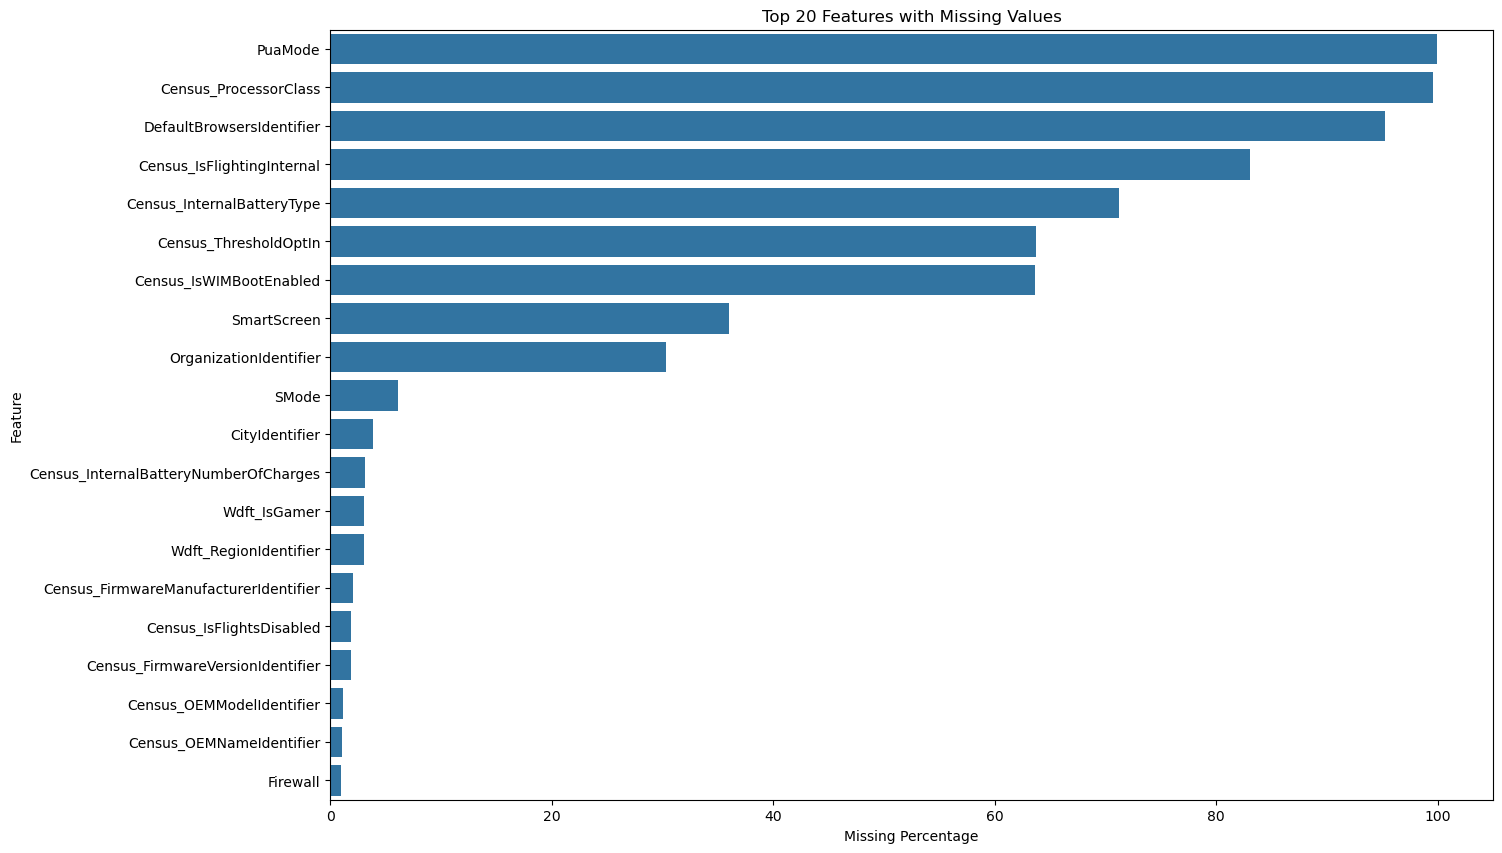


--- Guidance for Top 20 Features with Missing Values ---
This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.
Consider the following actions:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.
- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.


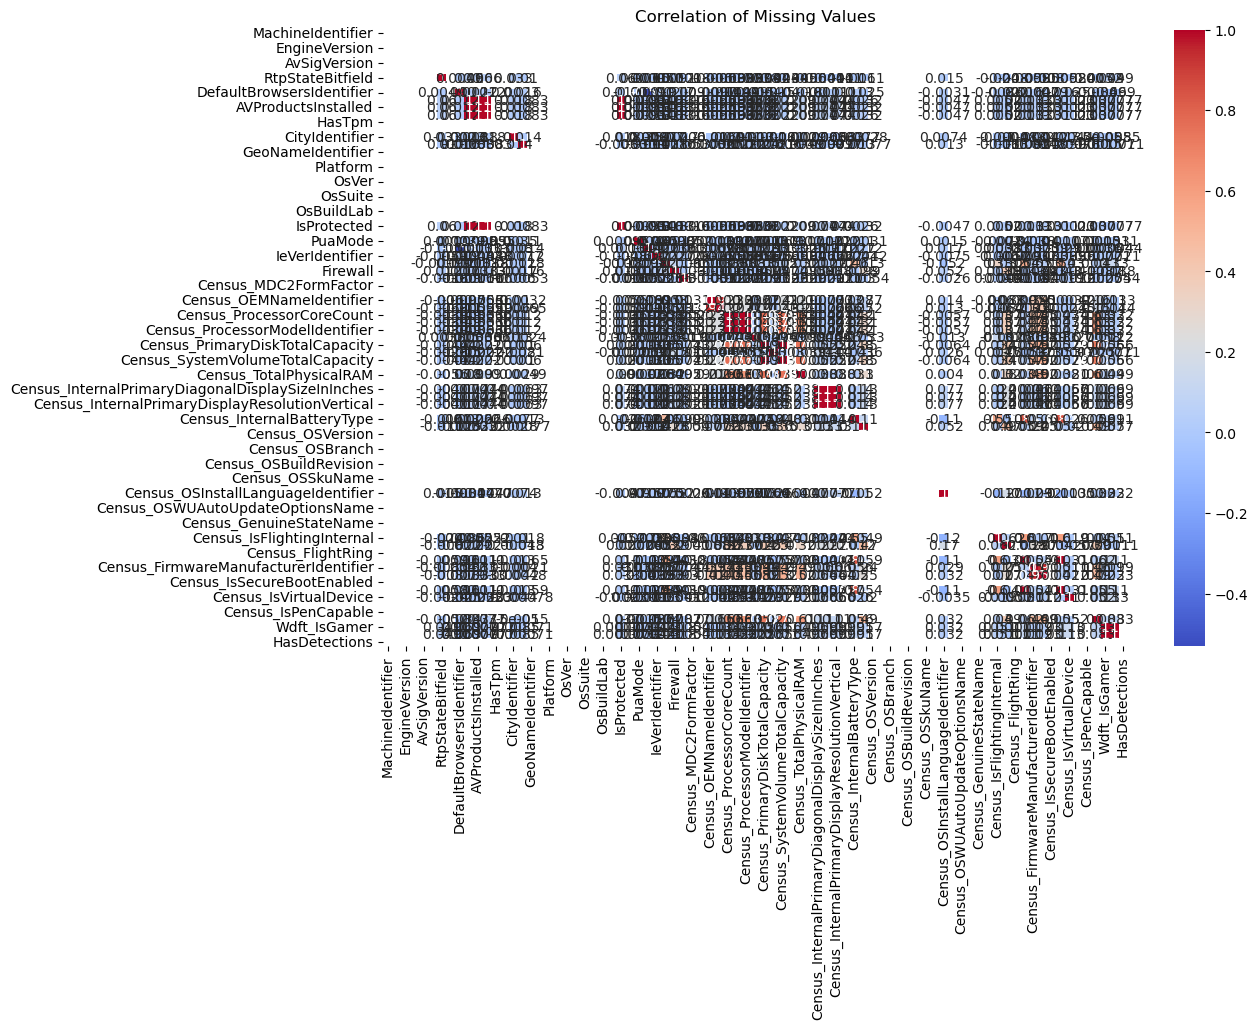


--- Guidance for Correlation of Missing Values ---
This heatmap shows the correlation between missing values of different features.
High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.
Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.


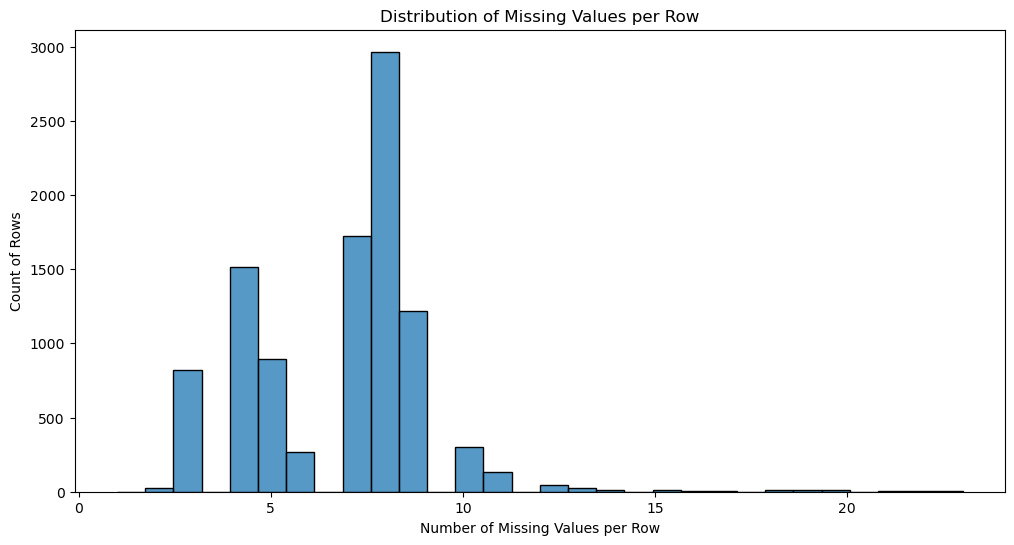


--- Guidance for Distribution of Missing Values per Row ---
This histogram shows the distribution of the number of missing values per row in the dataset.
Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.
                                                   CorrelationWithTarget
AVProductStatesIdentifier                                       0.111348
IsProtected                                                     0.065207
Census_TotalPhysicalRAM                                         0.059147
Census_PrimaryDiskTotalCapacity                                 0.054558
Census_ProcessorCoreCount                                       0.050934
Wdft_IsGamer                                                    0.047980
RtpStateBitfield                                                0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches               0.029988
LocaleEnglishNameIdentifier 

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 20 and the vector passed to `y` has length 52.

<Figure size 1500x1000 with 0 Axes>

In [2]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, save_yaml, save_json_file, clean_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Load feature metadata and manual updates
feature_metadata_path = paths['config']['feature_metadata']
manual_update_path = paths['config']['manual_feature_classification_update']
feature_metadata = load_yaml(feature_metadata_path)
manual_updates = load_yaml(manual_update_path)['manual_feature_classification_updates']

# Update the classified_data_type attribute in feature_metadata.yaml
for update in manual_updates:
    feature = update['Feature']
    new_classification = update['Manual Review and Update']
    if feature in feature_metadata['features']:
        feature_metadata['features'][feature]['classified_data_type'] = new_classification
    else:
        print(f"Feature {feature} not found in the existing metadata.")
save_yaml(feature_metadata, feature_metadata_path)

# Separate features into numeric and categorical based on classified_data_type
numeric_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'numerical']
categorical_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'categorical']

# Imputation strategies
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.named_steps['classifier'].feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df.head(20))  # Display the top 20 features

# Save the feature importance to a file
analysis_results_dir = paths['reports']['univariate_analysis']
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df.head(20))

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Calculate the correlation of missing values with each other
missing_corr = train_sample.isnull().corr()

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Feature Importances ---")
print("This bar plot displays the top 20 features based on their importance in the Random Forest model.")
print("Features with higher importance values contribute more significantly to the model's predictions.")
print("Consider focusing on these features for feature engineering and understanding their role in the model.")

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
missing_values = missing_values.sort_values(by='missing_percentage', ascending=False)

# Display the missing values table
print(missing_values.head(20))

# Save the missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plot missing values table
plt.figure(figsize=(15, 10))
sns.barplot(x='missing_percentage', y='column_name', data=missing_values.head(20))
plt.title('Top 20 Features with Missing Values')
plt.xlabel('Missing Percentage')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Features with Missing Values ---")
print("This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.")
print("Consider the following actions:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Guidance
print("\n--- Guidance for Correlation of Missing Values ---")
print("This heatmap shows the correlation between missing values of different features.")
print("High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.")
print("Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.")

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Guidance
print("\n--- Guidance for Distribution of Missing Values per Row ---")
print("This histogram shows the distribution of the number of missing values per row in the dataset.")
print("Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.")

# Clean up the temporary column
train_sample.drop(columns=['missing_count_per_row'], inplace=True)

# Load feature correlation with target from metadata
feature_corr_with_target = {f: meta['correlation_with_target'] for f, meta in feature_metadata['features'].items() if 'correlation_with_target' in meta}

# Filter out non-numeric correlation values
feature_corr_with_target = {k: v for k, v in feature_corr_with_target.items() if isinstance(v, (int, float))}

# Create DataFrame for feature correlation with target
feature_corr_with_target_df = pd.DataFrame.from_dict(feature_corr_with_target, orient='index', columns=['CorrelationWithTarget'])
feature_corr_with_target_df = feature_corr_with_target_df.astype(float).sort_values(by='CorrelationWithTarget', ascending=False)

# Display feature correlation with target table
print(feature_corr_with_target_df.head(20))

# Plot feature correlation with target
plt.figure(figsize=(15, 10))
sns.barplot(x='CorrelationWithTarget', y=feature_corr_with_target_df.index, data=feature_corr_with_target_df.head(20))
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Feature Correlation with Target ---")
print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
print("Focus on these features for feature engineering and model building.")

print("\n--- Contextual Insights and Recommendations ---")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")
print("- Rows with >50% missing values: Consider dropping these rows or using advanced imputation techniques.")
print("- Features with high correlation to target: Pay special attention to these features as their missingness might contain predictive information.")


                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
10                               Census_TotalPhysicalRAM    0.009233
6                     Census_OSInstallLanguageIdentifier    0.008208
342                    AVProductStatesIdentifier_53447.0    0.007858
1                                    AVProductsInstalled    0.007753
4      Census_InternalPrimaryDisplayResolutionHorizontal    0.007200
5        Census_InternalPrimaryDisplayResolutionVertical    0.006315
8                              Census_ProcessorCoreCount    0.006088
2                  Census_InternalBatteryNumberOfCharges    0.005938
13683                          Eng

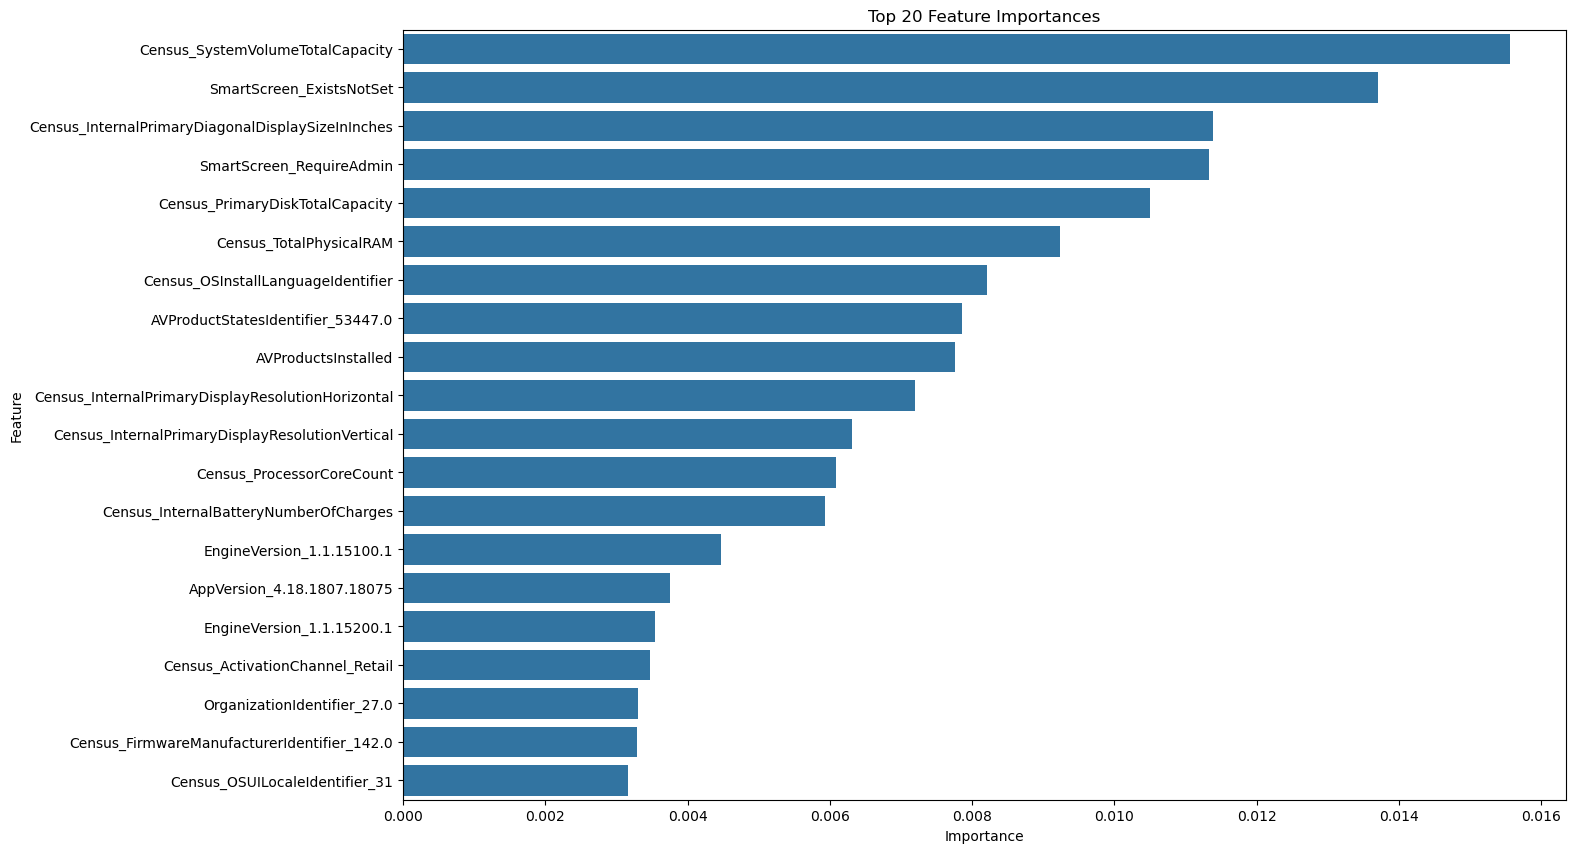


--- Guidance for Top 20 Feature Importances ---
This bar plot displays the top 20 features based on their importance in the Random Forest model.
Features with higher importance values contribute more significantly to the model's predictions.
Consider focusing on these features for feature engineering and understanding their role in the model.
                              column_name  missing_count  missing_percentage
28                                PuaMode           9997               99.97
41                  Census_ProcessorClass           9958               99.58
8               DefaultBrowsersIdentifier           9528               95.28
68             Census_IsFlightingInternal           8309               83.09
52             Census_InternalBatteryType           7120               71.20
71                  Census_ThresholdOptIn           6372               63.72
75                Census_IsWIMBootEnabled           6361               63.61
31                            SmartScr

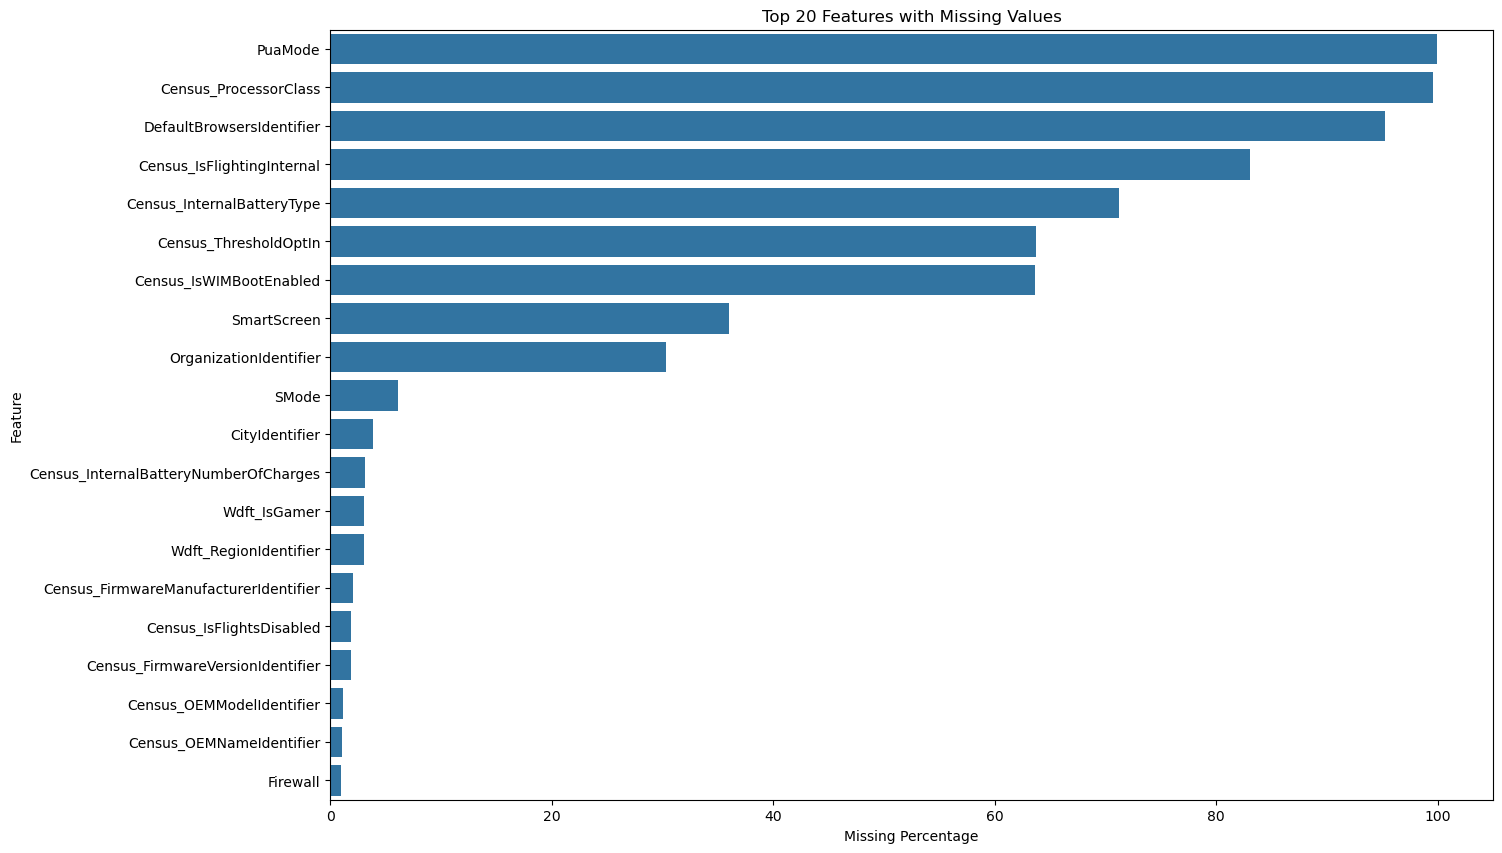


--- Guidance for Top 20 Features with Missing Values ---
This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.
Consider the following actions:
- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.
- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.
- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.


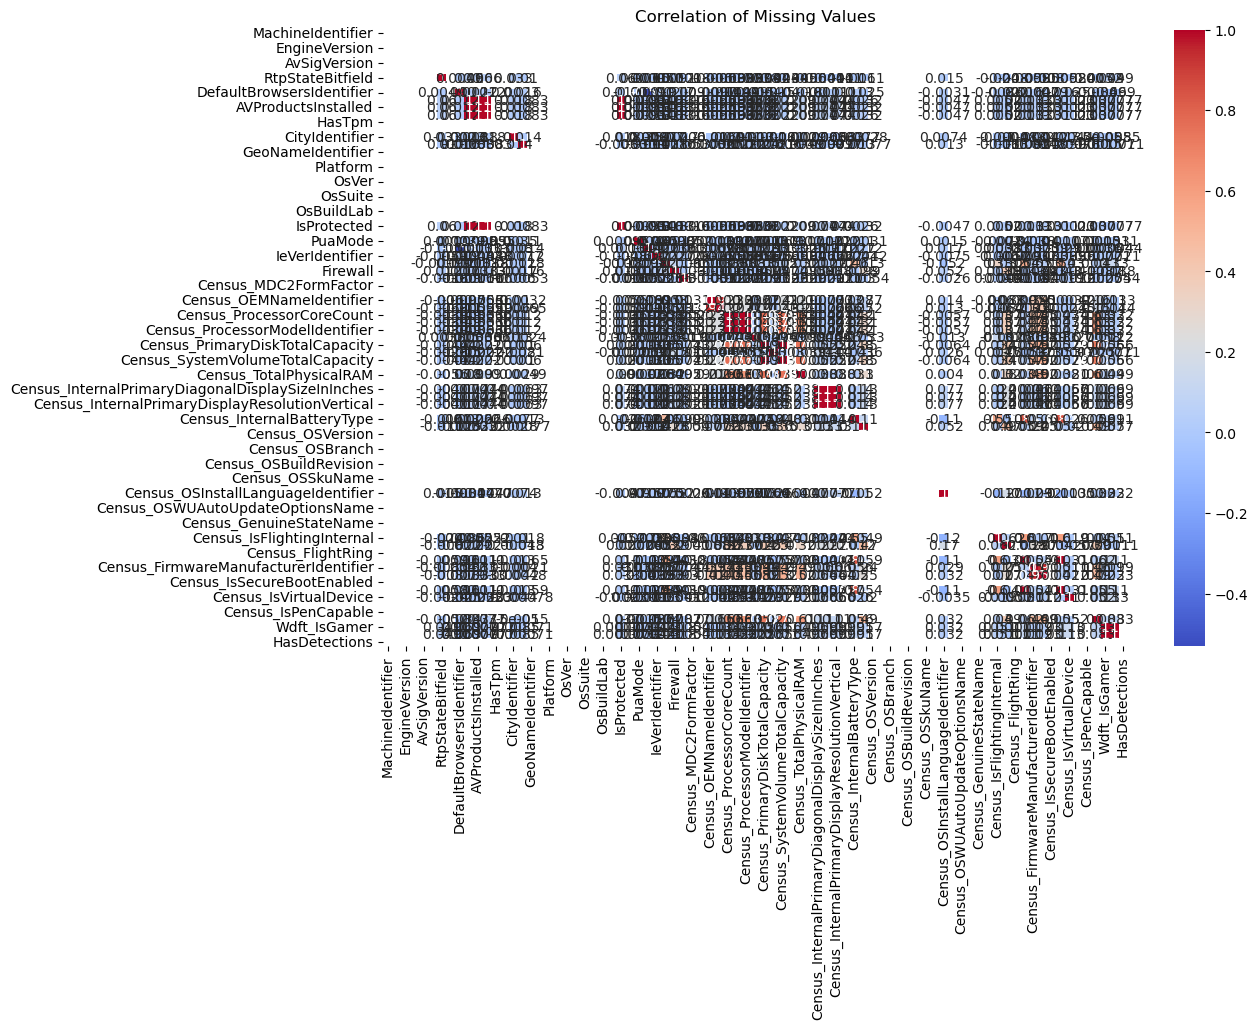


--- Guidance for Correlation of Missing Values ---
This heatmap shows the correlation between missing values of different features.
High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.
Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.


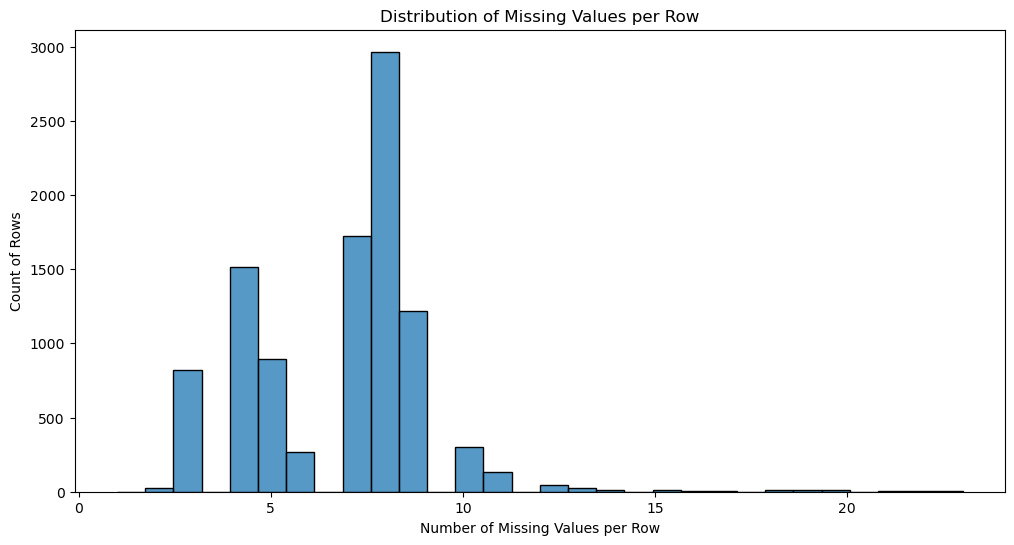


--- Guidance for Distribution of Missing Values per Row ---
This histogram shows the distribution of the number of missing values per row in the dataset.
Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.
                                                   CorrelationWithTarget
AVProductStatesIdentifier                                       0.111348
IsProtected                                                     0.065207
Census_TotalPhysicalRAM                                         0.059147
Census_PrimaryDiskTotalCapacity                                 0.054558
Census_ProcessorCoreCount                                       0.050934
Wdft_IsGamer                                                    0.047980
RtpStateBitfield                                                0.031184
Census_InternalPrimaryDiagonalDisplaySizeInInches               0.029988
LocaleEnglishNameIdentifier 

ValueError: Length of Index vectors must match length of `data` when both are used, but `data` has length 20 and the vector passed to `y` has length 52.

<Figure size 1500x1000 with 0 Axes>

In [2]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, save_yaml, save_json_file, clean_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Load feature metadata and manual updates
feature_metadata_path = paths['config']['feature_metadata']
manual_update_path = paths['config']['manual_feature_classification_update']
feature_metadata = load_yaml(feature_metadata_path)
manual_updates = load_yaml(manual_update_path)['manual_feature_classification_updates']

# Update the classified_data_type attribute in feature_metadata.yaml
for update in manual_updates:
    feature = update['Feature']
    new_classification = update['Manual Review and Update']
    if feature in feature_metadata['features']:
        feature_metadata['features'][feature]['classified_data_type'] = new_classification
    else:
        print(f"Feature {feature} not found in the existing metadata.")
save_yaml(feature_metadata, feature_metadata_path)

# Separate features into numeric and categorical based on classified_data_type
numeric_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'numerical']
categorical_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'categorical']

# Imputation strategies
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.named_steps['classifier'].feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df.head(20))  # Display the top 20 features

# Save the feature importance to a file
analysis_results_dir = paths['reports']['univariate_analysis']
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df.head(20))

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Calculate the correlation of missing values with each other
missing_corr = train_sample.isnull().corr()

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plotting
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Feature Importances ---")
print("This bar plot displays the top 20 features based on their importance in the Random Forest model.")
print("Features with higher importance values contribute more significantly to the model's predictions.")
print("Consider focusing on these features for feature engineering and understanding their role in the model.")

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
missing_values = missing_values.sort_values(by='missing_percentage', ascending=False)

# Display the missing values table
print(missing_values.head(20))

# Save the missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Plot missing values table
plt.figure(figsize=(15, 10))
sns.barplot(x='missing_percentage', y='column_name', data=missing_values.head(20))
plt.title('Top 20 Features with Missing Values')
plt.xlabel('Missing Percentage')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Top 20 Features with Missing Values ---")
print("This bar plot displays the top 20 features with the highest percentage of missing values in the dataset.")
print("Consider the following actions:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")

plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Guidance
print("\n--- Guidance for Correlation of Missing Values ---")
print("This heatmap shows the correlation between missing values of different features.")
print("High correlation values (closer to 1 or -1) indicate that the missingness of one feature is strongly related to the missingness of another feature.")
print("Use this information to decide on joint imputation strategies or to understand underlying patterns in the data.")

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Guidance
print("\n--- Guidance for Distribution of Missing Values per Row ---")
print("This histogram shows the distribution of the number of missing values per row in the dataset.")
print("Identify rows with a high number of missing values (e.g., more than 50% missing values) and consider dropping these rows or applying robust imputation methods.")

# Clean up the temporary column
train_sample.drop(columns=['missing_count_per_row'], inplace=True)

# Load feature correlation with target from metadata
feature_corr_with_target = {f: meta['correlation_with_target'] for f, meta in feature_metadata['features'].items() if 'correlation_with_target' in meta}

# Filter out non-numeric correlation values
feature_corr_with_target = {k: v for k, v in feature_corr_with_target.items() if isinstance(v, (int, float))}

# Create DataFrame for feature correlation with target
feature_corr_with_target_df = pd.DataFrame.from_dict(feature_corr_with_target, orient='index', columns=['CorrelationWithTarget'])
feature_corr_with_target_df = feature_corr_with_target_df.astype(float).sort_values(by='CorrelationWithTarget', ascending=False)

# Display feature correlation with target table
print(feature_corr_with_target_df.head(20))

# Plot feature correlation with target
plt.figure(figsize=(15, 10))
sns.barplot(x='CorrelationWithTarget', y=feature_corr_with_target_df.index, data=feature_corr_with_target_df.head(20))
plt.title('Top 20 Features Correlated with Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.show()

# Guidance
print("\n--- Guidance for Feature Correlation with Target ---")
print("This bar plot shows the top 20 features with the highest correlation with the target variable.")
print("High absolute correlation values (closer to 1 or -1) indicate a strong relationship between the feature and the target variable.")
print("Focus on these features for feature engineering and model building.")

print("\n--- Contextual Insights and Recommendations ---")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values:")
print("- Features with >50% missing values: Consider dropping these features or using domain-specific imputation.")
print("- Features with 10%-50% missing values: Apply imputation techniques such as mean/median/mode imputation, regression imputation, or machine learning models.")
print("- Features with <10% missing values: Use simple imputation techniques like mean/median/mode imputation.")
print("- Rows with >50% missing values: Consider dropping these rows or using advanced imputation techniques.")
print("- Features with high correlation to target: Pay special attention to these features as their missingness might contain predictive information.")


In [2]:
# notebooks/01_data_understanding/01g_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.common import load_yaml, save_yaml, save_json_file, clean_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Load feature metadata and manual updates
feature_metadata_path = paths['config']['feature_metadata']
manual_update_path = paths['config']['manual_feature_classification_update']
feature_metadata = load_yaml(feature_metadata_path)
manual_updates = load_yaml(manual_update_path)['manual_feature_classification_updates']

# Update the classified_data_type attribute in feature_metadata.yaml
for update in manual_updates:
    feature = update['Feature']
    new_classification = update['Manual Review and Update']
    if feature in feature_metadata['features']:
        feature_metadata['features'][feature]['classified_data_type'] = new_classification
    else:
        print(f"Feature {feature} not found in the existing metadata.")
save_yaml(feature_metadata, feature_metadata_path)

# Separate features into numeric and categorical based on classified_data_type
numeric_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'numerical']
categorical_features = [f for f, meta in feature_metadata['features'].items() if meta['classified_data_type'] == 'categorical']

# Imputation strategies
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.named_steps['classifier'].feature_importances_
features = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df)

# Save the feature importance to a file
analysis_results_dir = paths['reports']['univariate_analysis']
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df)

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

print("\n--- Contextual Insights and Recommendations ---\n")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values, such as imputation, deletion, or using algorithms that can handle missing data natively.")


                                                 Feature  Importance
9                       Census_SystemVolumeTotalCapacity    0.015562
22324                           SmartScreen_ExistsNotSet    0.013709
3      Census_InternalPrimaryDiagonalDisplaySizeInInches    0.011390
22328                           SmartScreen_RequireAdmin    0.011330
7                        Census_PrimaryDiskTotalCapacity    0.010504
...                                                  ...         ...
11649                             CityIdentifier_74438.0    0.000000
14577  MachineIdentifier_0004d833f28dc7c8aafee718e635...    0.000000
14578  MachineIdentifier_0004d8a39ac1fe8d005f75bb9b88...    0.000000
11642                             CityIdentifier_74257.0    0.000000
16983  MachineIdentifier_001ae114e1e86869e95ebb304eb2...    0.000000

[22345 rows x 2 columns]
Empty DataFrame
Columns: [CorrelationWithTarget]
Index: []

--- Contextual Insights and Recommendations ---

High-Level Overview: The missing valu


==== Missing Values Analysis ====

                                          column_name  missing_count  \
6                                    RtpStateBitfield             34   
8                           DefaultBrowsersIdentifier           9528   
9                           AVProductStatesIdentifier             30   
10                                AVProductsInstalled             30   
11                                  AVProductsEnabled             30   
14                                     CityIdentifier            383   
15                             OrganizationIdentifier           3028   
26                                        IsProtected             30   
28                                            PuaMode           9997   
29                                              SMode            609   
30                                    IeVerIdentifier             75   
31                                        SmartScreen           3604   
32                          

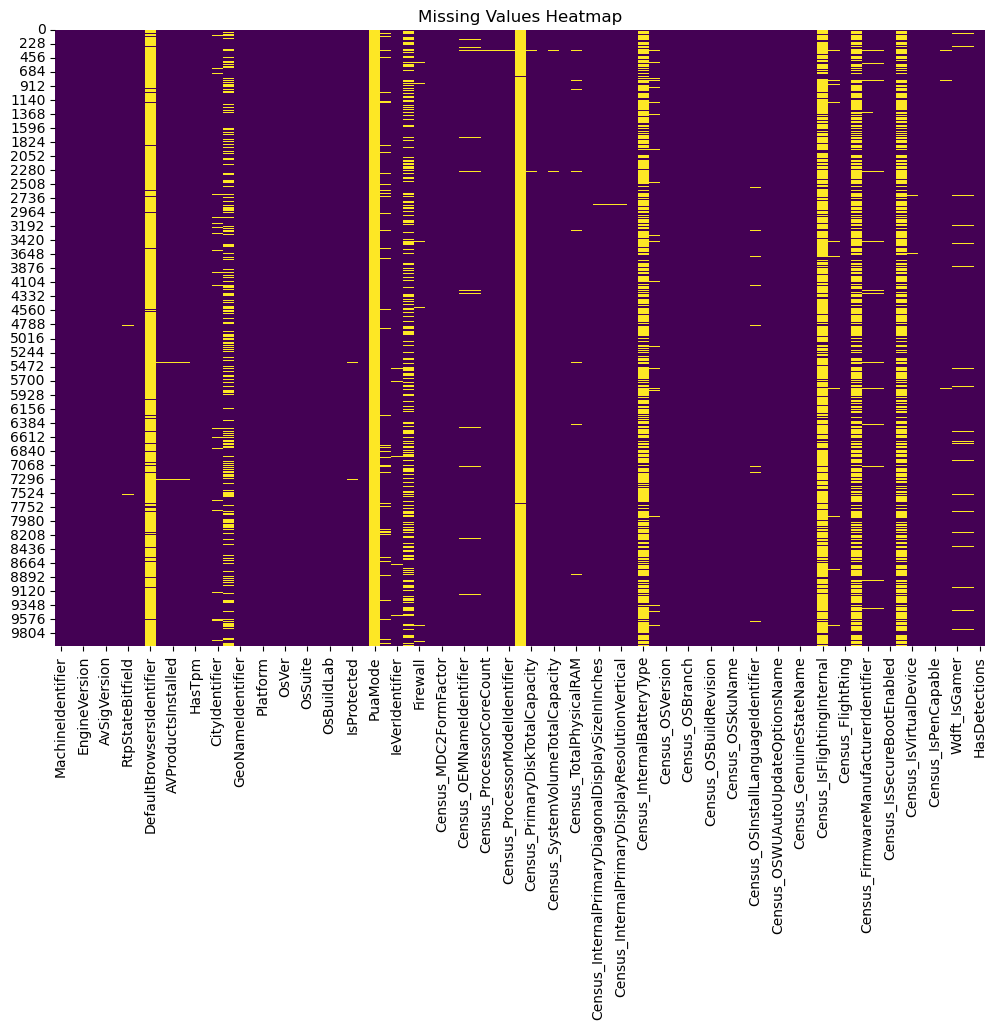

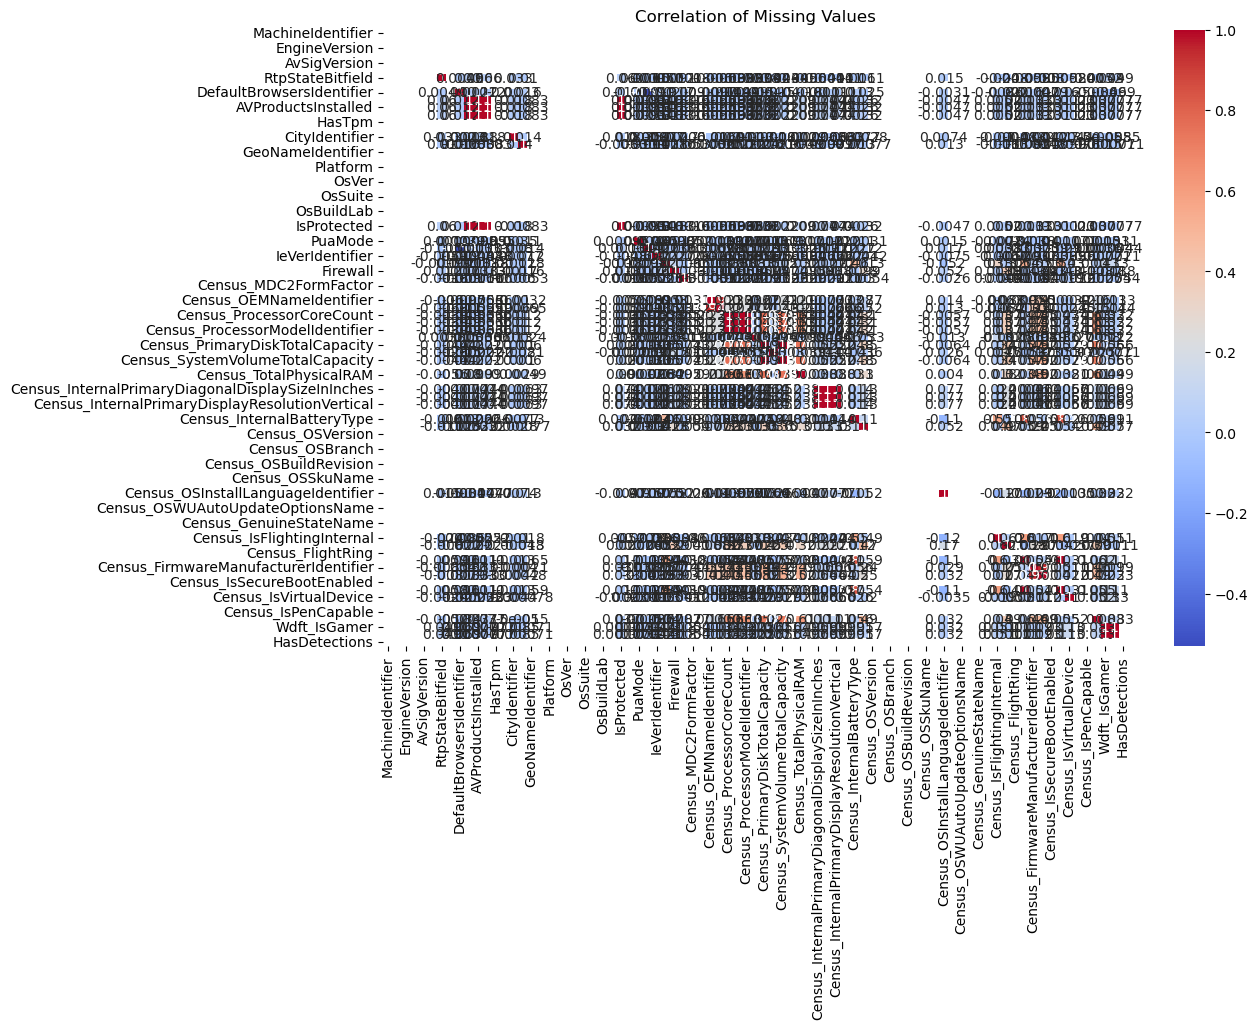

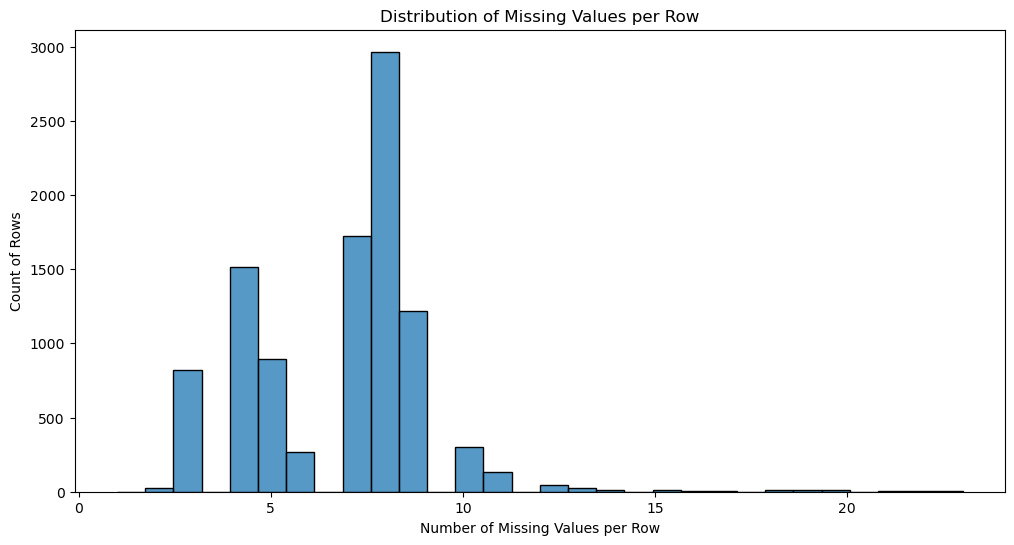

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '0000028988387b115f69f31a3bf04f09'

In [2]:
# notebooks/01_data_understanding/01e_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.json_utils import save_to_json
from src.utils.common import save_analysis_results, ensure_directories_exist, clean_json_file, save_json_file, load_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Directory to save analysis results
analysis_results_dir = paths['reports']['univariate_analysis']
os.makedirs(analysis_results_dir, exist_ok=True)

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
print("\n==== Missing Values Analysis ====\n")
print(missing_values)

# Save missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Visual Inspection: Missingness Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_sample.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Analysis of Missing Values
missing_corr = train_sample.isnull().corr()

# Save missing correlation to JSON
missing_corr_dict = missing_corr.to_dict()
save_json_file(missing_corr_dict, os.path.join(analysis_results_dir, 'missing_values_correlation.json'))

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

# Save missing count per row to JSON
missing_count_per_row = train_sample['missing_count_per_row'].value_counts().reset_index()
missing_count_per_row.columns = ['missing_count', 'row_count']
missing_count_per_row_dict = missing_count_per_row.set_index('missing_count').T.to_dict()
save_json_file(missing_count_per_row_dict, os.path.join(analysis_results_dir, 'missing_count_per_row.json'))

# Visualize the distribution of missing values per row
plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Remove the temporary column
train_sample.drop(columns=['missing_count_per_row'], inplace=True)

# Feature Importance Analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = train_sample.drop(columns=['HasDetections'])
y = train_sample['HasDetections']

# Handle missing values (for simplicity, using mean imputation)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Extract feature importance
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df)

# Save the feature importance to a file
importance_df.to_csv(os.path.join(analysis_results_dir, 'feature_importance.csv'), index=False)

# Correlation with Target Variable
# Create binary features indicating missing values
missing_indicators = X.isnull().astype(int)

# Add the target variable to the missing indicators DataFrame
missing_indicators['HasDetections'] = y.values

# Calculate the correlation with the target variable
correlation_with_target = missing_indicators.corr()['HasDetections'].drop('HasDetections')

# Create a DataFrame for correlation with the target
correlation_with_target_df = pd.DataFrame(correlation_with_target, columns=['CorrelationWithTarget'])
correlation_with_target_df = correlation_with_target_df.sort_values(by='CorrelationWithTarget', ascending=False)

# Print the correlation with the target variable
print(correlation_with_target_df)

# Save the correlation with the target variable to a file
correlation_with_target_df.to_csv(os.path.join(analysis_results_dir, 'correlation_with_target.csv'))

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

print("\n--- Contextual Insights and Recommendations ---\n")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values, such as imputation, deletion, or using algorithms that can handle missing data natively.")



==== Missing Values Analysis ====

                                          column_name  missing_count  \
6                                    RtpStateBitfield             34   
8                           DefaultBrowsersIdentifier           9528   
9                           AVProductStatesIdentifier             30   
10                                AVProductsInstalled             30   
11                                  AVProductsEnabled             30   
14                                     CityIdentifier            383   
15                             OrganizationIdentifier           3028   
26                                        IsProtected             30   
28                                            PuaMode           9997   
29                                              SMode            609   
30                                    IeVerIdentifier             75   
31                                        SmartScreen           3604   
32                          

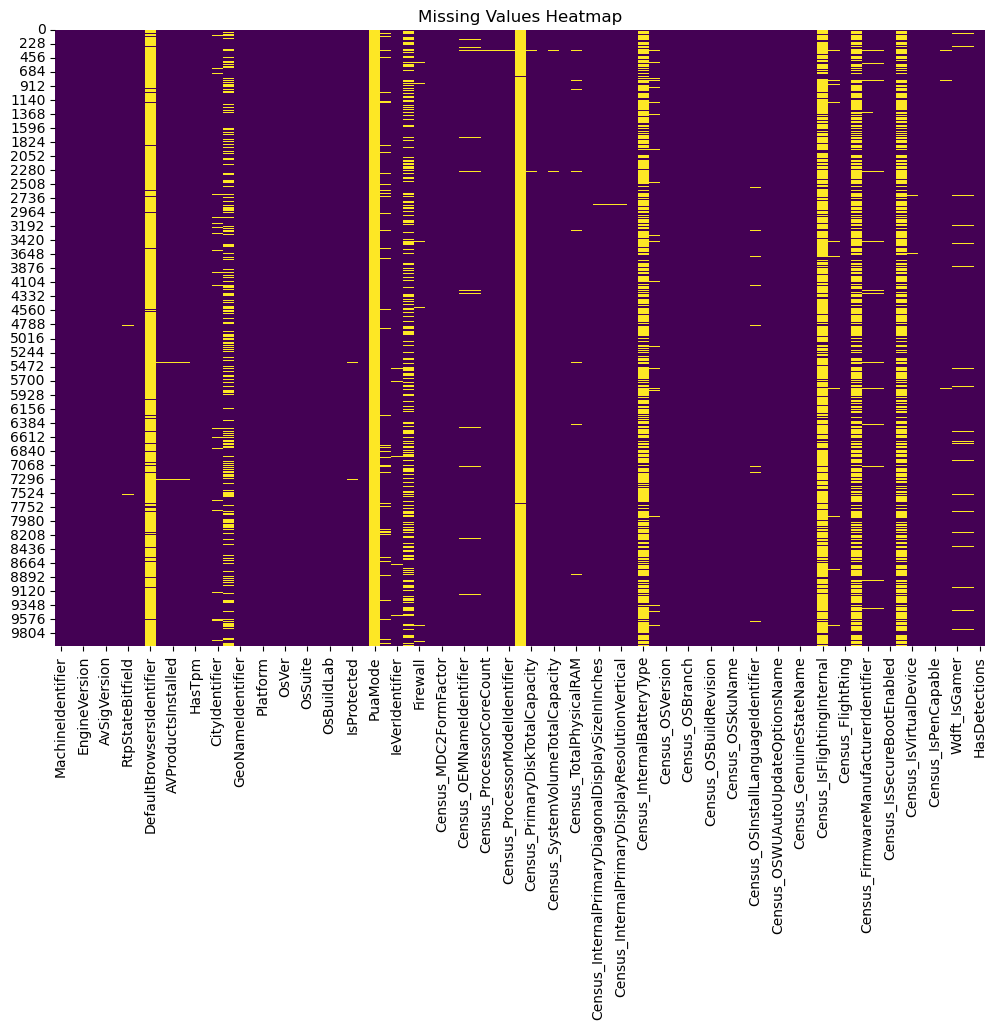

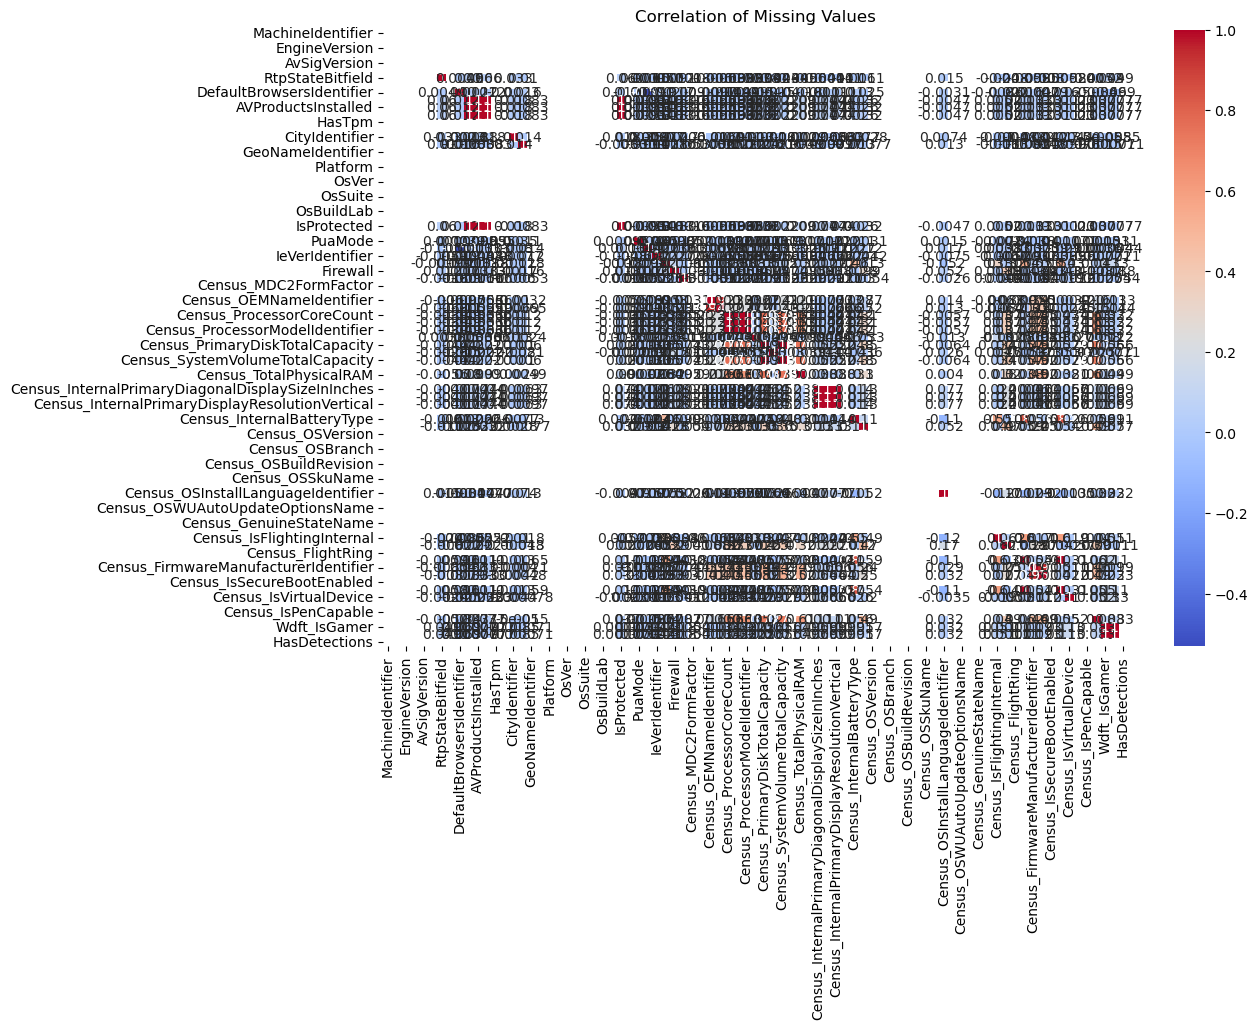

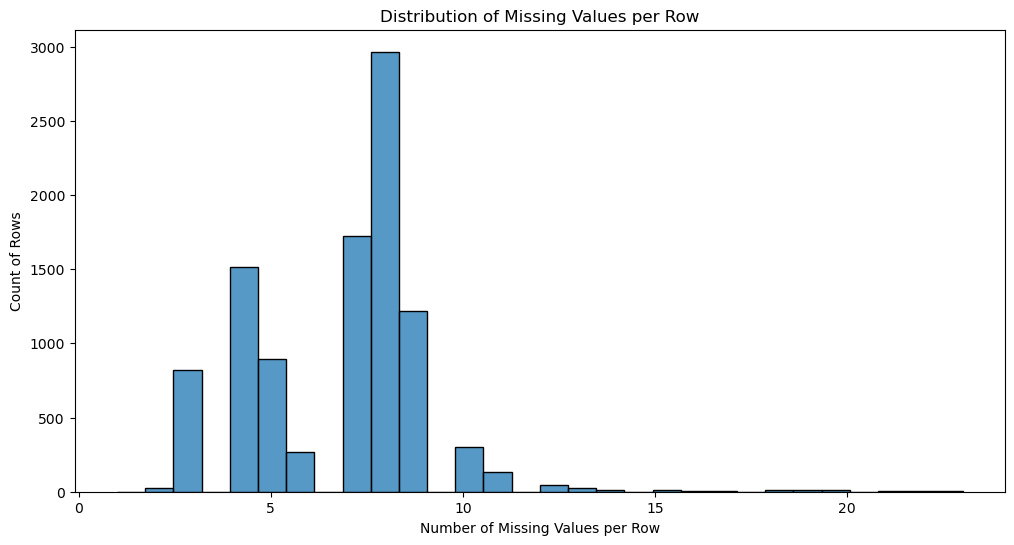


--- Contextual Insights and Recommendations ---

High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.
Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.
Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values, such as imputation, deletion, or using algorithms that can handle missing data natively.


In [2]:
# notebooks/01_data_understanding/01e_missing_values_analysis.ipynb

import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the project root and adjust paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
os.chdir(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary custom modules
from src.data.load_data import load_sample_data
from src.config_loader import load_paths
from src.utils.json_utils import save_to_json
from src.utils.common import save_analysis_results, ensure_directories_exist, clean_json_file, save_json_file, load_json_file

# Load configuration paths and data
paths = load_paths()
train_sample, test_sample = load_sample_data(nrows=10000)

# Directory to save analysis results
analysis_results_dir = paths['reports']['univariate_analysis']
os.makedirs(analysis_results_dir, exist_ok=True)

# Missing Values Analysis
missing_values = train_sample.isnull().sum().reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values[missing_values['missing_count'] > 0]
missing_values['missing_percentage'] = (missing_values['missing_count'] / len(train_sample)) * 100
print("\n==== Missing Values Analysis ====\n")
print(missing_values)

# Save missing values analysis to JSON
missing_values_dict = missing_values.set_index('column_name').T.to_dict()
save_json_file(missing_values_dict, os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

# Visual Inspection: Missingness Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_sample.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Correlation Analysis of Missing Values
missing_corr = train_sample.isnull().corr()

# Save missing correlation to JSON
missing_corr_dict = missing_corr.to_dict()
save_json_file(missing_corr_dict, os.path.join(analysis_results_dir, 'missing_values_correlation.json'))

# Plot heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Missing Values')
plt.show()

# Pattern Analysis: Count of Missing Values per Row
train_sample['missing_count_per_row'] = train_sample.isnull().sum(axis=1)

# Save missing count per row to JSON
missing_count_per_row = train_sample['missing_count_per_row'].value_counts().reset_index()
missing_count_per_row.columns = ['missing_count', 'row_count']
missing_count_per_row_dict = missing_count_per_row.set_index('missing_count').T.to_dict()
save_json_file(missing_count_per_row_dict, os.path.join(analysis_results_dir, 'missing_count_per_row.json'))

# Visualize the distribution of missing values per row
plt.figure(figsize=(12, 6))
sns.histplot(train_sample['missing_count_per_row'], bins=30)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Count of Rows')
plt.show()

# Remove the temporary column
train_sample.drop(columns=['missing_count_per_row'], inplace=True)

# Clean up the JSON file
clean_json_file(os.path.join(analysis_results_dir, 'missing_values_analysis.json'))

print("\n--- Contextual Insights and Recommendations ---\n")
print("High-Level Overview: The missing values analysis helps identify the extent and patterns of missing data in the dataset.")
print("Detailed Technical Insights: The visualizations and correlation analysis reveal how missing values are distributed and whether there are any patterns or correlations.")
print("Actionable Recommendations: Based on this analysis, develop a strategy for handling missing values, such as imputation, deletion, or using algorithms that can handle missing data natively.")
